
<p align="center">
    <img src="https://github.com/GeostatsGuy/GeostatsPy/blob/master/TCG_color_logo.png?raw=true" width="220" height="240" />

</p>

## Temporal Fusion Transformer-Based Surrogate Flow Model


### Eduardo Maldonado Cruz, Graduate Research Assistant, The University of Texas at Austin

#### [Twitter](https://twitter.com/emaldonadocruz) | [GitHub](https://github.com/emaldonadocruz) | [LinkedIn](https://www.linkedin.com/in/eduardo-maldonado-8386a898/)

### Michael Pyrcz, Associate Professor, The University of Texas at Austin 

#### [Twitter](https://twitter.com/geostatsguy) | [GitHub](https://github.com/GeostatsGuy) | [Website](http://michaelpyrcz.com) | [GoogleScholar](https://scholar.google.com/citations?user=QVZ20eQAAAAJ&hl=en&oi=ao) | [Book](https://www.amazon.com/Geostatistical-Reservoir-Modeling-Michael-Pyrcz/dp/0199731446) | [YouTube](https://www.youtube.com/channel/UCLqEr-xV-ceHdXXXrTId5ig)  | [LinkedIn](https://www.linkedin.com/in/michael-pyrcz-61a648a1)

## Executive Summmary

Forecasting is crucial for optimizing subsurface resource development. However, the precision of current forecasting techniques depend on assumptions regarding boundary conditions, reservoir heterogeneity, and rock and fluid properties. Current data-driven methods are limited to analyzing one well at a time, cannot account for production constraints, lack interpretability, and are unable to include uncertainty in their predictions.

If Temporal Fusion Transformers (TFT) can incorporate both static and dynamic predictor features during forecasting, then a workflow that generates an interpretable TFT-based surrogate flow model could be used to forecast fluid flow and pressure across multiple wells with uncertainty estimation through quantile regression.

This chapter presents a novel workflow to generate an interpretable TFT-based surrogate flow model to forecast fluid flow and pressure across multiple wells with uncertainty. This chapter proposes two static predictor features to include location, and to improve model interpretability, SHAP values are calculated to relate forecasts to attention head weights at each time step.

## Library importing

In [1]:
#%% Libraries

import os
import warnings

warnings.filterwarnings("ignore")  # avoid printing out absolute paths
import matplotlib.pyplot as plt
os.chdir(os.getcwd())

import copy
from pathlib import Path
import warnings

import numpy as np
import pandas as pd
import pytorch_lightning as pl
from pytorch_lightning.callbacks import EarlyStopping, LearningRateMonitor
from pytorch_lightning.loggers import TensorBoardLogger
import torch

from pytorch_forecasting import Baseline, TemporalFusionTransformer, TimeSeriesDataSet
from pytorch_forecasting.data import GroupNormalizer
from pytorch_forecasting.metrics import SMAPE, PoissonLoss, QuantileLoss
from pytorch_forecasting.models.temporal_fusion_transformer.tuning import optimize_hyperparameters

import matplotlib.pyplot as plt

import pickle
import joblib

from pytorch_forecasting.models.temporal_fusion_transformer.tuning import optimize_hyperparameters

import imageio
import os

from matplotlib.pyplot import cm

Format for figures

In [2]:
plt.style.use('https://raw.githubusercontent.com/emaldonadocruz/Publication_figure_style/master/Publication_figure_style.mplstyle')

## Dataset load

In [3]:
data = pd.read_csv('Train-no_noise-schedule.csv')

In [4]:
data.head()

,well,rate,pressure,poro,perm,posy,posx,date,time_idx,operation
0,0,120954.667799,2500.0,0.153116,0.640000,99,99,2018-01-01,0,No_event
1,0,4618.661121,2500.0,0.151415,0.634776,99,99,2018-01-02,1,No_event
2,0,4306.162841,2500.0,0.151410,0.634761,99,99,2018-01-03,2,No_event
3,0,4191.729939,2500.0,0.151408,0.634758,99,99,2018-01-04,3,No_event
4,0,4104.265841,2500.0,0.151406,0.634755,99,99,2018-01-05,4,No_event


In [5]:
data.sort_values('time_idx',inplace=True)

### Location-based predictor features

In [6]:
X = 1000,
Y = 850
h = 10
data['distance'] = np.sqrt((data.posx-X)**2+(data.posy-Y)**2)
data['kh'] = data.perm*h
data['phih'] = data.poro*h

data['feat_kh'] = data['kh']/data.distance
data['feat_phih'] = data['phih']/data.distance

In [7]:
data.head(-10)

,well,rate,pressure,poro,perm,posy,posx,date,time_idx,operation,distance,kh,phih,feat_kh,feat_phih
0,0,120954.667799,2500.000000,0.153116,0.640000,99,99,2018-01-01,0,No_event,1172.945864,6.400000,1.531159,0.005456,0.001305
7665,8,236449.492946,2600.000000,0.150447,0.640000,1699,99,2018-01-01,0,No_event,1237.983037,6.400000,1.504466,0.005170,0.001215
1095,1,5478.721029,2600.000000,0.089651,0.640000,299,99,2018-01-01,0,No_event,1056.125939,6.400000,0.896508,0.006060,0.000849
6570,7,6958.137776,2600.000000,0.140468,0.640000,1499,99,2018-01-01,0,No_event,1110.406232,6.400000,1.404681,0.005764,0.001265
4380,4,617330.939014,2600.000000,0.081222,0.640000,899,99,2018-01-01,0,No_event,902.331425,6.400000,0.812217,0.007093,0.000900
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3283,2,979.965294,1479.211419,0.114229,0.630925,499,99,2020-12-29,1093,No_event,966.955014,6.309252,1.142290,0.006525,0.001181
5473,4,974.173177,1568.908836,0.079753,0.631438,899,99,2020-12-29,1093,No_event,902.331425,6.314376,0.797534,0.006998,0.000884
2188,1,1360.338362,1479.292420,0.088125,0.631945,299,99,2020-12-29,1093,No_event,1056.125939,6.319452,0.881247,0.005984,0.000834
8758,8,826.592778,1570.155034,0.147893,0.631968,1699,99,2020-12-29,1093,No_event,1237.983037,6.319684,1.478929,0.005105,0.001195


In [8]:
data.drop(['kh','phih','distance'],axis=1,inplace=True)

## Data visualization

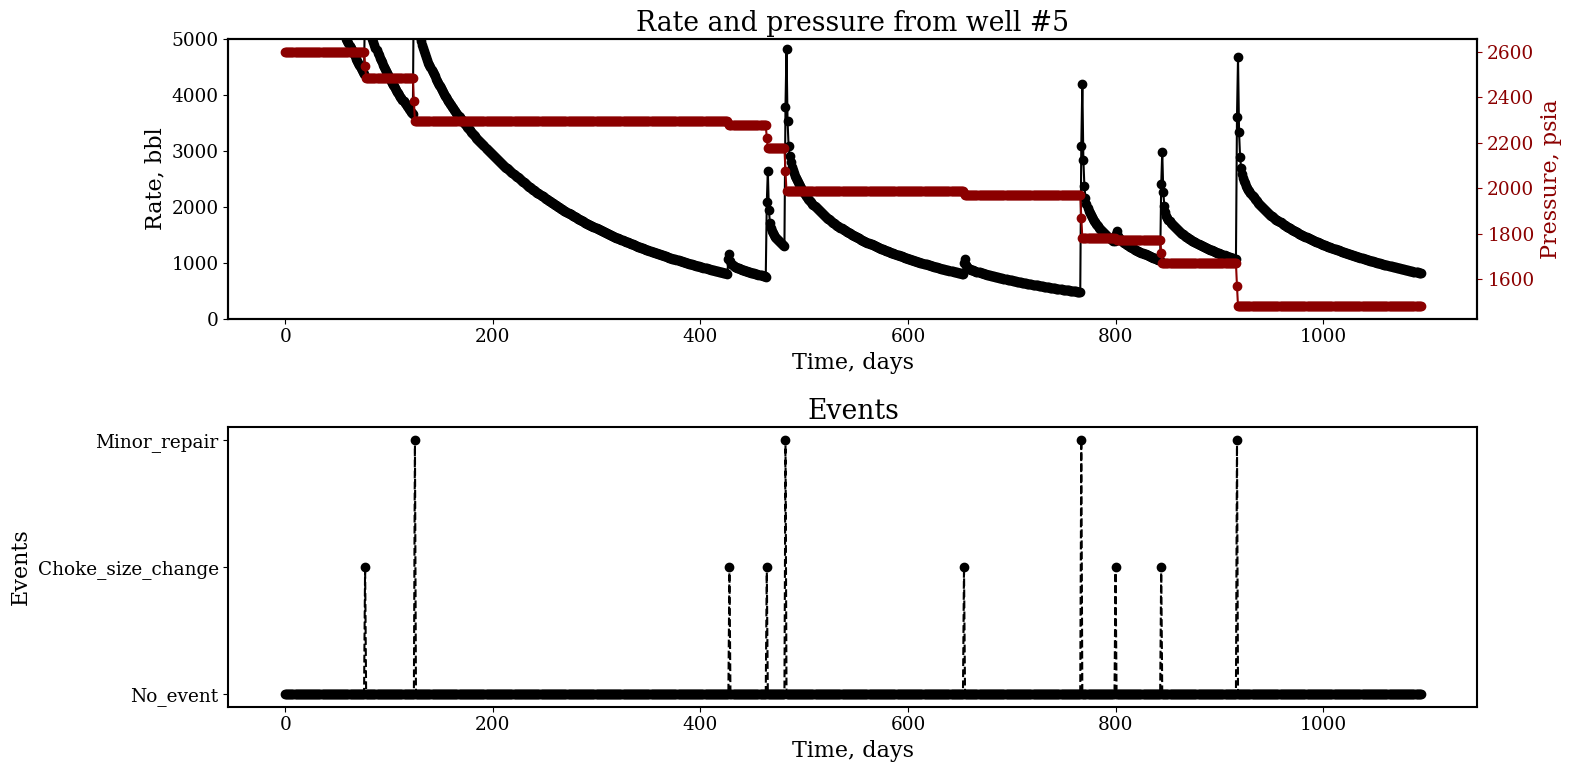

In [9]:
well = 5

fig, axs = plt.subplots(2,1,figsize=(16,8))
ax = axs[0]
im = ax.plot(data[data.well==well].time_idx,data[data.well==well].rate,'-ko',label=f'Well {well}')
ax.set_ylim(0,5000)
ax.set_ylabel('Rate, bbl')
ax.set_xlabel('Time, days')
ax.set_title(f'Rate and pressure from well #{well}')

ax2 = ax.twinx()
ax2.plot(data[data.well==well].time_idx,data[data.well==well].pressure,'-o',color='darkred',label=f'Well {well}')
ax2.set_ylabel('Pressure, psia')
ax2.yaxis.label.set_color('darkred')
ax2.tick_params(axis='y',colors='darkred')
#ax.set_ylim(350,450)
#fig.colorbar(im, ax = axs[0], pad = 0.01)

ax = axs[1]
im = ax.plot(data[data.well==well].time_idx,data[data.well==well].operation,'--ko',label=f'Well {well}')
ax.set_ylabel('Events')
ax.set_xlabel('Time, days')
ax.set_title('Events')
#ax.set_ylim(350,450)
#fig.colorbar(im, ax = axs[1], pad = 0.01)

fig.tight_layout()
#plt.savefig('Figure_4-Production_history_of_well_7.png',dpi=300)


## Final dataset

In [10]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8760 entries, 0 to 8759
Data columns (total 12 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   well       8760 non-null   int64  
 1   rate       8760 non-null   float64
 2   pressure   8760 non-null   float64
 3   poro       8760 non-null   float64
 4   perm       8760 non-null   float64
 5   posy       8760 non-null   int64  
 6   posx       8760 non-null   int64  
 7   date       8760 non-null   object 
 8   time_idx   8760 non-null   int64  
 9   operation  8760 non-null   object 
 10  feat_kh    8760 non-null   float64
 11  feat_phih  8760 non-null   float64
dtypes: float64(6), int64(4), object(2)
memory usage: 889.7+ KB


## Define model

In [11]:
max_prediction_length = 14
max_encoder_length = 70

max_epochs=50

study_name = f"Study_mel{max_encoder_length}_mpl{max_prediction_length}_EF_v2"
study_name

'Study_mel70_mpl14_EF_v2'

## Functions

In [12]:
cmap = plt.get_cmap('Greys')
color = cm.Greys(np.linspace(0.5, 1, 5))

Weights_pos = np.linspace(0,0.25,max_prediction_length)
Weights_neg = np.linspace(0,1,max_prediction_length)

def return_qresiduals(out):
    Quantiles_res = np.zeros([out['prediction'].shape[1],out['prediction'].shape[2]])
    for i in range(out['prediction'].shape[2]):
        Quantiles_res[:,i] = out['prediction'][0,:,i] - return_p50(out['prediction'][0])
    return Quantiles_res

def return_quantiles(out,Weights_neg,Weights_pos,P50,Quantiles_res):
    Quantiles = np.zeros([out['prediction'].shape[1],out['prediction'].shape[2]])
    for j in range(Quantiles_res.shape[0]):
        for i in range(Quantiles_res.shape[1]):
            if Quantiles_res[j,i]<0:
                Quantiles[j,i] = P50[j]+Weights_neg[j]*Quantiles_res[j,i]
            if Quantiles_res[j,i]==0:
                Quantiles[j,i] = P50[j]
            if Quantiles_res[j,i]>0:
                Quantiles[j,i] = P50[j]+Weights_pos[j]*Quantiles_res[j,i]
    return Quantiles

def return_attention(attention):
    return np.mean(attention[0,:,:].numpy(),axis = 0 )

def return_p50(tensor):
    return np.percentile(tensor,50,axis=1)

def return_p10(tensor):
    return np.percentile(tensor,10,axis=1)

def return_p90(tensor):
    return np.percentile(tensor,90,axis=1)

def make_plot(x,out,idx):
# all true values for y of the first sample in batch
    #idx=0

    #out = raw_predictions

    encoder_target = x["encoder_target"]
    decoder_target = x["decoder_target"]

    y_raw = out["prediction"]  # raw predictions - used for calculating loss
    y_hat = out['prediction']
    y_quantile = out['prediction'] # quantiles of shape batch_size x timesteps x n_quantiles

    y_all = torch.cat([encoder_target[0], decoder_target[0]])

    max_encoder_length = x["encoder_lengths"].max()

    y = torch.cat((y_all[: x["encoder_lengths"][idx]],
                   y_all[max_encoder_length : (max_encoder_length + x["decoder_lengths"][idx])]))

    y_hat = y_hat.detach().cpu()[idx, : x["decoder_lengths"][idx]]
    y_quantile = y_quantile.detach().cpu()[idx, : x["decoder_lengths"][idx]]
    
    #Added
    qresiduals = return_qresiduals(out)
    y_quantile = return_quantiles(out,Weights_neg,Weights_pos,return_p50(y_hat),qresiduals)
    
    y_raw = y_raw.detach().cpu()[idx, : x["decoder_lengths"][idx]]

    y = y.detach().cpu()
    n_pred = y_hat.shape[0]
    x_obs = np.arange(-(y.shape[0] - n_pred), 0)
    x_pred = np.arange(n_pred)

    fig,ax = plt.subplots()
    ax2 = ax.twinx()
    
    for i in range(y_quantile.shape[1] // 2):
        if len(x_pred) > 1:
            ax.fill_between(x_pred, y_quantile[:, i], y_quantile[:, -i - 1], alpha=0.45,color = color[i])
        else:
            quantiles = torch.tensor([[y_quantile[0, i]], [y_quantile[0, -i - 1]]])
            ax.errorbar(x_pred, y[[-n_pred]], yerr=quantiles - y[-n_pred], capsize=1.0)

    lns1 = ax.plot(x_pred, return_p50(y_hat), label="Predicted", c = 'red')
    lns2 = ax.plot(x_obs, y[:-n_pred], label="Observed", c='black',linewidth=2)
    ax.plot(x_pred, y[-n_pred:], c='black',linewidth=2)
    #ax.plot(x_obs, y[:-n_pred], label="observed", c='black')
    
    lns3 = ax2.plot(x_obs,return_attention(raw_prediction['encoder_attention'][0]),'--',color = 'gray',label = 'Encoder attention')
    ax2.set_ylabel('Attention')
    
    ax.set_ylabel('Rate [bbl]')
    ax.set_xlabel('Periods [days]')
    
    lns = lns1 + lns2 + lns3
    labs = [l.get_label() for l in lns]
    ax.legend(lns, labs, loc=0)
    
def make_plot_separate_att(x,out,idx):
# all true values for y of the first sample in batch
    #idx=0

    #out = raw_predictions

    encoder_target = x["encoder_target"]
    decoder_target = x["decoder_target"]

    y_raw = out["prediction"]  # raw predictions - used for calculating loss
    y_hat = out['prediction']
    y_quantile = out['prediction'] # quantiles of shape batch_size x timesteps x n_quantiles

    y_all = torch.cat([encoder_target[0], decoder_target[0]])

    max_encoder_length = x["encoder_lengths"].max()

    y = torch.cat((y_all[: x["encoder_lengths"][idx]],
                   y_all[max_encoder_length : (max_encoder_length + x["decoder_lengths"][idx])]))

    y_hat = y_hat.detach().cpu()[idx, : x["decoder_lengths"][idx]]
    y_quantile = y_quantile.detach().cpu()[idx, : x["decoder_lengths"][idx]]
    
    #Added
    qresiduals = return_qresiduals(out)
    y_quantile = return_quantiles(out,Weights_neg,Weights_pos,return_p50(y_hat),qresiduals)
    
    y_raw = y_raw.detach().cpu()[idx, : x["decoder_lengths"][idx]]

    y = y.detach().cpu()
    n_pred = y_hat.shape[0]
    x_obs = np.arange(-(y.shape[0] - n_pred), 0)
    x_pred = np.arange(n_pred)

    fig,ax = plt.subplots()
    ax2 = ax.twinx()
    #ax3 = ax.twinx()
    
    for i in range(y_quantile.shape[1] // 2):
        if len(x_pred) > 1:
            ax.fill_between(x_pred, y_quantile[:, i], y_quantile[:, -i - 1], alpha=0.45,color = color[i])
        else:
            quantiles = torch.tensor([[y_quantile[0, i]], [y_quantile[0, -i - 1]]])
            ax.errorbar(x_pred, y[[-n_pred]], yerr=quantiles - y[-n_pred], capsize=1.0)

    lns1 = ax.plot(x_pred, return_p50(y_hat), label="Predicted", c = 'red')
    lns2 = ax.plot(x_obs, y[:-n_pred], label="Observed", c='black',linewidth=2)
    ax.plot(x_pred, y[-n_pred:], c='black',linewidth=2)
    #ax.plot(x_obs, y[:-n_pred], label="observed", c='black')
    
    #ax2.plot(x_obs,return_attention(raw_prediction['encoder_attention'][0]),'--',color = 'gray')
    lns3 = ax2.plot(x_obs,
         raw_prediction['encoder_attention'][0, 0, 0, :],'--',
         label='Attention head #1')
#     lns4 = ax2.plot(x_obs,
#              raw_prediction['encoder_attention'][0, 0, 1, :],'--',
#              label='Attention head #2')
#     ax2.plot(x_obs,
#              raw_prediction['encoder_attention'][0, 0, 2, :],'--',
#              label='Attention head #3')
#     ax2.set_ylabel('Attention')
    
    #ax3.plot()

    lns = lns1 + lns2 + lns3 #+ lns4
    labs = [l.get_label() for l in lns]
    ax.legend(lns, labs, loc=0)
    
    ax.set_ylabel('Rate [bbl]')
    ax.set_xlabel('Periods [days]')
    plt.show()
    
def make_test_plot_quantiles(x,out,idx):
# all true values for y of the first sample in batch
    #idx=0

    #out = raw_predictions

    encoder_target = x["encoder_target"]
    decoder_target = x["decoder_target"]

    y_raw = out["prediction"]  # raw predictions - used for calculating loss
    y_hat = out['prediction']
    y_quantile = out['prediction'] # quantiles of shape batch_size x timesteps x n_quantiles

    y_all = torch.cat([encoder_target[0], decoder_target[0]])

    max_encoder_length = x["encoder_lengths"].max()

    y = torch.cat((y_all[: x["encoder_lengths"][idx]],
                   y_all[max_encoder_length : (max_encoder_length + x["decoder_lengths"][idx])]))

    y_hat = y_hat.detach().cpu()[idx, : x["decoder_lengths"][idx]]
    y_quantile = y_quantile.detach().cpu()[idx, : x["decoder_lengths"][idx]]
    
    #Added
    qresiduals = return_qresiduals(out)
    y_quantile = return_quantiles(out,Weights_neg,Weights_pos,return_p50(y_hat),qresiduals)
    
    y_raw = y_raw.detach().cpu()[idx, : x["decoder_lengths"][idx]]

    y = y.detach().cpu()
    n_pred = y_hat.shape[0]
    x_obs = np.arange(-(y.shape[0] - n_pred), 0)
    x_pred = np.arange(n_pred)

    fig,ax = plt.subplots()
    ax2 = ax.twinx()
    
    for i in range(y_quantile.shape[1] // 2):
        if len(x_pred) > 1:
            ax.fill_between(x_pred, y_quantile[:, i], y_quantile[:, -i - 1], alpha=0.45,color = color[i])
        else:
            quantiles = torch.tensor([[y_quantile[0, i]], [y_quantile[0, -i - 1]]])
            ax.errorbar(x_pred, y[[-n_pred]], yerr=quantiles - y[-n_pred], capsize=1.0)

    lns1 = ax.plot(x_pred, return_p50(y_hat), label="Predicted", c = 'red')
    lns2 = ax.plot(x_obs, y[:-n_pred], label="Observed", c='black',linewidth=2)
    ax.plot(x_pred, y[-n_pred:], c='black',linewidth=2)
    #ax.plot(x_obs, y[:-n_pred], label="observed", c='black')
    
    lns3 = ax2.plot(x_obs,return_attention(raw_prediction['encoder_attention'][0]),'--',color = 'gray',label = 'Encoder attention')
    ax2.set_ylabel('Attention')
    
    ax.set_ylabel('Rate [bbl]')
    ax.set_xlabel('Periods [days]')
    
    lns = lns1 + lns2 + lns3
    labs = [l.get_label() for l in lns]
    ax.legend(lns, labs, loc=0)
    
def make_plot_separate_att_with_events(x,out,events):
# all true values for y of the first sample in batch
    idx=0

    #out = raw_predictions

    encoder_target = x["encoder_target"]
    decoder_target = x["decoder_target"]

    y_raw = out["prediction"]  # raw predictions - used for calculating loss
    y_hat = out['prediction']
    y_quantile = out['prediction'] # quantiles of shape batch_size x timesteps x n_quantiles

    y_all = torch.cat([encoder_target[0], decoder_target[0]])

    max_encoder_length = x["encoder_lengths"].max()

    y = torch.cat((y_all[: x["encoder_lengths"][idx]],
                   y_all[max_encoder_length : (max_encoder_length + x["decoder_lengths"][idx])]))

    y_hat = y_hat.detach().cpu()[idx, : x["decoder_lengths"][idx]]
    y_quantile = y_quantile.detach().cpu()[idx, : x["decoder_lengths"][idx]]
    
    #Added
    qresiduals = return_qresiduals(out)
    y_quantile = return_quantiles(out,Weights_neg,Weights_pos,return_p50(y_hat),qresiduals)
    
    y_raw = y_raw.detach().cpu()[idx, : x["decoder_lengths"][idx]]

    y = y.detach().cpu()
    n_pred = y_hat.shape[0]
    x_obs = np.arange(-(y.shape[0] - n_pred), 0)
    x_pred = np.arange(n_pred)
    

    fig,ax = plt.subplots()
    
    for i in range(y_quantile.shape[1] // 2):
        if len(x_pred) > 1:
            ax.fill_between(x_pred, y_quantile[:, i], y_quantile[:, -i - 1], alpha=0.45,color = color[i])
        else:
            quantiles = torch.tensor([[y_quantile[0, i]], [y_quantile[0, -i - 1]]])
            ax.errorbar(x_pred, y[[-n_pred]], yerr=quantiles - y[-n_pred], capsize=1.0)

    
    lns2 = ax.plot(x_obs, y[:-n_pred], label="Observed", c='black',linewidth=2)
    ax.plot(x_pred, y[-n_pred:], c='black',linewidth=2)
    lns1 = ax.plot(x_pred, return_p50(y_hat), label="Predicted", c = 'red')
    
    
    ax.set_ylabel('Rate [bbl]')
    ax.set_xlabel('Periods [days]')
    
    ## For second axis
    ax2 = ax.twinx()
    
    lns3 = ax2.plot(x_obs,
         raw_prediction['encoder_attention'][0, 0, 0, :],'--',
         label='Attention head #1')
#     lns4 = ax2.plot(x_obs,
#              raw_prediction['encoder_attention'][0, 0, 1, :],'--',
#              label='Attention head #2')
    
    ax2.set_ylabel('Attention')
    
    ## For third axis
    ax3 = ax.twinx()
    ax3.spines.right.set_position(('axes',1.17)) #Separation to second axis
    ax3.scatter(x_obs,events,marker = 'o',color='black', s=8)
    ax3.set_ylabel('Events')
    
    ## Legends
    
    lns = lns1 + lns2 + lns3# + lns4
    labs = [l.get_label() for l in lns]
    ax.legend(lns, labs, loc=0, bbox_to_anchor=(-0.12,0.67))
    
#     if savefigs==True:
#         plt.savefig('')
    
    plt.show()
    
def return_events(data,well_number,time_idx_fp):
    data_sub = data[data['well']==well_number]
    events = data_sub['operation'][time_idx_fp+1-max_encoder_length:time_idx_fp+1]
    return events

def return_porosity_en(data,well_number,time_idx_fp):
    data_sub = data[data['well']==well_number]
    events = data_sub['poro'][time_idx_fp+1-max_encoder_length:time_idx_fp+1]
    return events

def return_permeability_en(data,well_number,time_idx_fp):
    data_sub = data[data['well']==well_number]
    events = data_sub['perm'][time_idx_fp+1-max_encoder_length:time_idx_fp+1]
    return events

def return_events_de(data,well_number,time_idx_fp):
    data_sub = data[data['well']==well_number]
    events = data_sub['operation'][time_idx_fp+1:time_idx_fp+1+max_prediction_length]
    return events

def return_porosity_de(data,well_number,time_idx_fp):
    data_sub = data[data['well']==well_number]
    events = data_sub['poro'][time_idx_fp+1:time_idx_fp+1+max_prediction_length]
    return events

def return_permeability_de(data,well_number,time_idx_fp):
    data_sub = data[data['well']==well_number]
    events = data_sub['perm'][time_idx_fp+1:time_idx_fp+1+max_prediction_length]
    return events

def generate_gif(Name):    
    file_list = []
    for file in os.listdir(weights_path):
        if file.endswith(".png"):
            #print(os.path.join(weights_path, file))
            file_list.append(file)
            
    with imageio.get_writer(f'{Name}.gif', mode='I') as writer:
        for filename in file_list:
            image = imageio.imread(filename)
            writer.append_data(image)

    for filename in set(file_list):
        os.remove(filename)

def create_mask(size, lengths, inverse: bool = False):
    """
    Create boolean masks of shape len(lenghts) x size.
    An entry at (i, j) is True if lengths[i] > j.
    Args:
        size (int): size of second dimension
        lengths (torch.LongTensor): tensor of lengths
        inverse (bool, optional): If true, boolean mask is inverted. Defaults to False.
    Returns:
        torch.BoolTensor: mask
    """

    if inverse:  # return where values are
        return torch.arange(size, device=lengths.device).unsqueeze(0) < lengths.unsqueeze(-1)
    else:  # return where no values are
        return torch.arange(size, device=lengths.device).unsqueeze(0) >= lengths.unsqueeze(-1)
    
def integer_histogram(data, min, max):
    
    uniques, counts = torch.unique(data, return_counts=True)
    if min is None:
        min = uniques.min()
    if max is None:
        max = uniques.max()
    hist = torch.zeros(max - min + 1, dtype=torch.long, device=data.device).scatter(
        dim=0, index=uniques - min, src=counts
    )
    return hist

def masked_op(tensor, op, dim, mask=None):
    if mask is None:
        mask = ~torch.isnan(tensor)
    masked = tensor.masked_fill(~mask, 0.0)
    summed = masked.sum(dim=dim)
    if op == "mean":
        return summed / mask.sum(dim=dim)  # Find the average
    elif op == "sum":
        return summed
    else:
        raise ValueError(f"unkown operation {op}")

def interpret_output(out,reduction='sum',attention_prediction_horizon = 0):
    # take attention and concatenate if a list to proper attention object
    batch_size = len(out["decoder_attention"])

    ## Decoder attention
    
    decoder_attention = out["decoder_attention"]
    print(decoder_attention.shape)
    decoder_mask = create_mask(out["decoder_attention"].size(1), out["decoder_lengths"])
    print(decoder_mask.shape)
    decoder_attention[decoder_mask[..., None, None].expand_as(decoder_attention)] = float("nan")
    print(decoder_attention.shape)
    
    ## Encoder attention
    # roll encoder attention (so start last encoder value is on the right)
    encoder_attention = out["encoder_attention"]
    shifts = encoder_attention.size(3) - out["encoder_lengths"]
    new_index = (
        torch.arange(encoder_attention.size(3), device=encoder_attention.device)[None, None, None].expand_as(
            encoder_attention
        )
        - shifts[:, None, None, None]
    ) % encoder_attention.size(3)
    encoder_attention = torch.gather(encoder_attention, dim=3, index=new_index)
    # expand encoder_attentiont to full size
    if encoder_attention.size(-1) < max_encoder_length:
        encoder_attention = torch.concat(
            [
                torch.full(
                    (
                        *encoder_attention.shape[:-1],
                        max_encoder_length - out["encoder_lengths"].max(),
                    ),
                    float("nan"),
                    dtype=encoder_attention.dtype,
                    device=encoder_attention.device,
                ),
                encoder_attention,
            ],
            dim=-1,
        )

        # combine attention vector
    attention = torch.concat([encoder_attention, decoder_attention], dim=-1)
    print(attention.shape)
    attention[attention < 1e-5] = float("nan")
    
    # histogram of decode and encode lengths
    encoder_length_histogram = integer_histogram(out["encoder_lengths"], min=0, max=max_encoder_length)
    decoder_length_histogram = integer_histogram(
        out["decoder_lengths"], min=1, max=out["decoder_variables"].size(1)
    )

    # mask where decoder and encoder where not applied when averaging variable selection weights
    encoder_variables = out["encoder_variables"].squeeze(-2)
    encode_mask = create_mask(encoder_variables.size(1), out["encoder_lengths"])
    encoder_variables = encoder_variables.masked_fill(encode_mask.unsqueeze(-1), 0.0).sum(dim=1)
    encoder_variables /= (
        out["encoder_lengths"]
        .where(out["encoder_lengths"] > 0, torch.ones_like(out["encoder_lengths"]))
        .unsqueeze(-1)
    )

    decoder_variables = out["decoder_variables"].squeeze(-2)
    decode_mask = create_mask(decoder_variables.size(1), out["decoder_lengths"])
    decoder_variables = decoder_variables.masked_fill(decode_mask.unsqueeze(-1), 0.0).sum(dim=1)
    decoder_variables /= out["decoder_lengths"].unsqueeze(-1)

    # static variables need no masking
    static_variables = out["static_variables"].squeeze(1)
    # attention is batch x time x heads x time_to_attend
    # average over heads + only keep prediction attention and attention on observed timesteps
    attention = masked_op(
        attention[
            :, attention_prediction_horizon, :, : max_encoder_length + attention_prediction_horizon
        ],
        op="mean",
        dim=1,
    )
    print(attention.shape)

    if reduction != "none":  # if to average over batches
        static_variables = static_variables.sum(dim=0)
        encoder_variables = encoder_variables.sum(dim=0)
        decoder_variables = decoder_variables.sum(dim=0)
        attention = masked_op(attention, dim=0, op=reduction)
    else:
        attention = attention / masked_op(attention, dim=1, op="sum").unsqueeze(-1)  # renormalize
    print(attention.shape)   
    interpretation = dict(
            attention=attention.masked_fill(torch.isnan(attention), 0.0),
            static_variables=static_variables,
            encoder_variables=encoder_variables,
            decoder_variables=decoder_variables,
            encoder_length_histogram=encoder_length_histogram,
            decoder_length_histogram=decoder_length_histogram,
        )
    
    return interpretation

def plot_interpretation(interpretation):
        figs = {}

        # attention
        fig, ax = plt.subplots()
        attention = interpretation["attention"].detach().cpu()
        attention = attention / attention.sum(-1).unsqueeze(-1)
        ax.plot(np.arange(-max_encoder_length, attention.size(0) - max_encoder_length), attention,color='black')
        ax.set_xlabel("Time index")
        ax.set_ylabel("Attention")
        ax.set_title("Attention")
        figs["attention"] = fig

        # variable selection
        def make_selection_plot(title, values, labels):
            fig, ax = plt.subplots(figsize=(7, len(values) * 0.25 + 2))
            order = np.argsort(values)
            values = values / values.sum(-1).unsqueeze(-1)
            ax.barh(np.arange(len(values)), values[order] * 100, tick_label=np.asarray(labels)[order], color = 'black',alpha = 0.85)
            ax.set_title(title)
            ax.set_xlabel("Importance in %")
            plt.tight_layout()
            return fig

        figs["static_variables"] = make_selection_plot(
            "Static variables importance", interpretation["static_variables"].detach().cpu(), tft.static_variables
        )
        figs["encoder_variables"] = make_selection_plot(
            "Encoder variables importance", interpretation["encoder_variables"].detach().cpu(), tft.encoder_variables
        )
        figs["decoder_variables"] = make_selection_plot(
            "Decoder variables importance", interpretation["decoder_variables"].detach().cpu(), tft.decoder_variables
        )

        return figs
    
def plot_attention(interpretation):
    figs = {}
    fig, ax = plt.subplots()
    attention = interpretation["attention"].detach().cpu()
    attention = attention / attention.sum(-1).unsqueeze(-1)
    ax.plot(np.arange(-max_encoder_length, attention.size(0) - max_encoder_length), attention,color='black')
    ax.set_xlabel("Time index")
    ax.set_ylabel("Attention")
    ax.set_title("Attention")
    figs["attention"] = fig
    
    return figs

def make_selection_plot(title, values, labels):
    fig, ax = plt.subplots(figsize=(7, len(values) * 0.25 + 2))
    order = np.argsort(values)
    values = values / values.sum(-1).unsqueeze(-1)
    ax.barh(np.arange(len(values)), values[order] * 100, tick_label=np.asarray(labels)[order], color = 'black',alpha = 0.85)
    ax.set_title(title)
    ax.set_xlabel("Importance in %")
    plt.tight_layout()
    return fig

def plot_static_variable_importance(interpretation):
    figs = {}
    figs["static_variables"] = make_selection_plot(
            "Static variables importance", interpretation["static_variables"].detach().cpu(), tft.static_variables)
    return figs

def plot_encoder_variables(interpretation):
    figs = {}
    figs["encoder_variables"] = make_selection_plot(
    "Encoder variables importance", interpretation["encoder_variables"].detach().cpu(), tft.encoder_variables)
    return figs

def plot_decoder_variables(interpretation):
    figs = {}
    figs["decoder_variables"] = make_selection_plot(
        "Decoder variables importance", interpretation["decoder_variables"].detach().cpu(), tft.decoder_variables)
    return figs

## Generate training dataset

In [13]:
training_cutoff = data["time_idx"].max() - 180#max_prediction_length*len(data.well.unique())
training_cutoff

914

In [14]:
training = TimeSeriesDataSet(data[lambda x: x.time_idx <= training_cutoff],
    time_idx="time_idx",
    target="rate",
    group_ids=['well'],
    min_encoder_length=max_encoder_length // 2,
    max_encoder_length=max_encoder_length,
    min_prediction_length=1,
    max_prediction_length=max_prediction_length,
    static_reals=['posx','posy'],
    time_varying_known_reals=['poro','perm'],
    time_varying_unknown_reals=["rate",
         "feat_kh",
         "feat_phih",],
    time_varying_known_categoricals=['operation']
)

In [15]:
validation = TimeSeriesDataSet.from_dataset(training, data, predict=True, stop_randomization=True)

# create dataloaders for model
batch_size = 32  # set this between 32 to 128
train_dataloader = training.to_dataloader(train=True, batch_size=batch_size, num_workers=0)
val_dataloader = validation.to_dataloader(train=False, batch_size=batch_size * 2, num_workers=0)



## Load model

Load a pre-trained model

In [16]:
weights_path = os.getcwd()
print(weights_path)

c:\Users\eduar\OneDrive\PhD\Research\Eduardo_Maldonado_Cruz\Multi-horizon Well Performance Forecasting with Temporal Fusion Transformers\Code-Workflow


In [17]:
from pytorch_lightning.callbacks import ModelCheckpoint

checkpoint_callback = ModelCheckpoint(
    dirpath="",
    filename=f"{study_name}"
)

In [18]:
import tensorflow as tf
import tensorboard as tb

tf.io.gfile = tb.compat.tensorflow_stub.io.gfile

### Hyperparameter tuning

This next part is time consuming, it is commented but it can be uncommented at any time. I have included the results in the next subsection

In [19]:
# # create study
# study = optimize_hyperparameters(
#     train_dataloader,
#     val_dataloader,
#     model_path=study_name,
#     n_trials=50,
#     max_epochs=max_epochs,
#     gradient_clip_val_range=(0.01, 1.0),
#     hidden_size_range=(8, 128),
#     hidden_continuous_size_range=(8, 128),
#     attention_head_size_range=(2, 4),
#     learning_rate_range=(0.001, 0.1),
#     dropout_range=(0.1, 0.3),
#     trainer_kwargs=dict(limit_train_batches=30),
#     reduce_on_plateau_patience=4,
#     use_learning_rate_finder=False,  # use Optuna to find ideal learning rate or use in-built learning rate finder
# )

# # save study results - also we can resume tuning at a later point in time
# with open(f"{study_name}.pkl", "wb") as fout:
#     pickle.dump(study, fout)

# # show best hyperparameters
# print(study.best_trial.params)

#### Results

In [20]:
study = joblib.load(f"{study_name}.pkl")
print("Best trial until now:")
print(" Value: ", study.best_trial.value)
print(" Params: ")
for key, value in study.best_trial.params.items():
    print(f"    {key}: {value}")

Best trial until now:
 Value:  2.4703266620635986
 Params: 
    gradient_clip_val: 0.062125981582032745
    hidden_size: 96
    dropout: 0.10137595333588358
    hidden_continuous_size: 64
    attention_head_size: 3
    learning_rate: 0.022632670195346684


## Train the model

In [21]:
study = joblib.load(study_name+'.pkl')

pl.seed_everything(42)

trainer = pl.Trainer(
    max_epochs=max_epochs,
    gpus=1,
    enable_model_summary=False,
    gradient_clip_val=study.best_trial.params['gradient_clip_val'],
    callbacks = [checkpoint_callback],
)

tft = TemporalFusionTransformer.from_dataset(
    training,
    learning_rate=study.best_trial.params['learning_rate'],
    hidden_size=study.best_trial.params['hidden_size'],
    attention_head_size=study.best_trial.params['attention_head_size'],
    dropout=study.best_trial.params['dropout'],
    hidden_continuous_size=study.best_trial.params['hidden_continuous_size'],
    output_size=7,
    loss=QuantileLoss(),
    reduce_on_plateau_patience=5,
)

Global seed set to 42
c:\Users\eduar\anaconda3\envs\tft\lib\site-packages\pytorch_lightning\trainer\connectors\accelerator_connector.py:441: LightningDeprecationWarning: Setting `Trainer(gpus=1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=1)` instead.
  rank_zero_deprecation(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Here you can train the model, however it is time consuming. I have included a pre-trained model that is loaded using:

```python
trainer.checkpoint_callback.best_model_path = f'{study_name}-v1.ckpt'
```

In [22]:
# trainer.fit(
#     tft,
#     train_dataloaders=train_dataloader,
#     val_dataloaders=val_dataloader,
# )

In [23]:
trainer.checkpoint_callback.best_model_path = f'{study_name}-v1.ckpt'

In [24]:
best_model_path = trainer.checkpoint_callback.best_model_path
best_tft = TemporalFusionTransformer.load_from_checkpoint(best_model_path)

In [25]:
raw_predictions, x = best_tft.predict(val_dataloader, mode="raw", return_x=True)

## Overall performance

Next we evaluate the overall performance of the model using Mean Absolute Error (MAE) and Symmetric Mean Absolute Percentage Error (SMAPE)

A common occurrence in previous works is that forecasts of pressure and rate are shifted by the lag used during training caused by autocorrelation. This phenomenon occurs when the input sequence is not informative enough to produce reliable forecasts. Then, the neural network repeats the last observed value. We use this concept to create two basic benchmark metrics to outperform based on the Mean Absolute Error (MAE) and Symmetric Mean Absolute Percentage Error (SMAPE) metrics in equations 8 and 9.

In [26]:
def smape(actual, predicted):
    actual = np.array(actual)
    predicted = np.array(predicted)

    denominator = (np.abs(actual) + np.abs(predicted)) / 2.0
    numerator = np.abs(actual - predicted)
    smape = np.mean(numerator / denominator) * 100
    return smape

def return_baseline(df,i):
    df = df[df['well']==i].reset_index()
    df['rate_shifted'] = df['rate'].shift(-1)
    df = df.iloc[1:-1]
    # df = df.drop(index=[0,len(df)-1])
    mae_val = (df['rate']-df['rate_shifted']).abs().mean()
    smape_val = smape(df['rate_shifted'].values,df['rate'].values)
    return mae_val, smape_val
    #return df

In [27]:
data_unsorted = pd.read_csv('Train-no_noise-schedule.csv')
#data_unsorted['rate_shifted'] = data_unsorted['rate'].shift(-1)

The baseline for well 0 is the following:

In [28]:
return_baseline(data_unsorted,0)

(19.49416237904491, 0.8774923042393116)

for all wells

In [29]:
val_list=[]
for i in data.well.unique():
    val_list.append(return_baseline(data_unsorted,i))

val_list = np.array(val_list)

The mean MAE and SMAPE in bbl and % are:

In [30]:
np.mean(val_list[:,0]),np.mean(val_list[:,1]*100)

(28.398541215447967, 114.8229578373903)

Obtain the raw predictions

In [31]:
raw_predictions, x = best_tft.predict(training.filter(lambda x: (x.well == 0) & (x.time_idx_first_prediction == 70)),
                                       mode="raw", return_x=True)

Loop over all predictions to obtain the mean MAE and mean SMAPE

In [32]:
well = 0
length_data = data.rate.shape[0]
prediction_time = max_encoder_length
mae = []
smape = []
for i in range(max_encoder_length,data[data.well==0].time_idx.max()-180):
    raw_predictions, x = best_tft.predict(training.filter(lambda x: (x.well == well) & (x.time_idx_first_prediction == i)),
                                       mode="raw", return_x=True)
    pred = raw_predictions['prediction'][0,:,3]
    true = x['decoder_target'][0,:]
    mae.append((pred-true).abs().mean())
    smape.append(SMAPE()(pred.view(1,-1),true.view(1,-1)))

In [33]:
print('These next values must be smaller than the baseline')
np.mean(mae),np.mean(smape)*100

These next values must be smaller than the baseline


(10.081815, 0.5388543009757996)

In [34]:
mae_array = np.asarray(mae)
smape_array = np.asarray(smape)

(-5.0, 100.0)

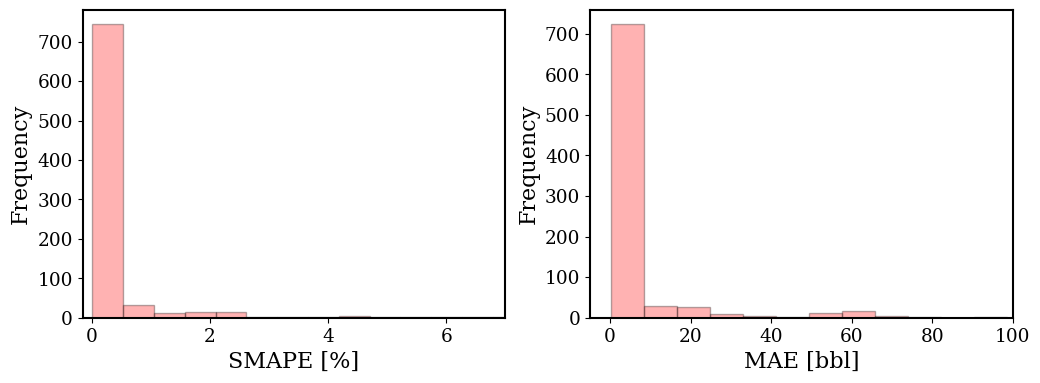

In [35]:
fig, axs = plt.subplots(1,2,figsize=(12,4),sharey=False)
ax = axs[0]
ax.hist(smape_array*100,bins=50, label = 'Error distribution with proposed predictor features',color='red',edgecolor = 'black',alpha = 0.3)
ax.set_xlabel('SMAPE [%]')
ax.set_ylabel('Frequency')
ax.set_xlim(-0.15,7)
#ax.legend()
# ax.set_ylim(0,700)
# ax.text(-0.75,720,'a)')

ax = axs[1]
ax.hist(mae_array,bins=50, label = 'Model #2 using proposed predictor features',color='red',edgecolor = 'black',alpha = 0.3)
ax.set_xlabel('MAE [bbl]')
ax.set_ylabel('Frequency')
ax.set_xlim(-5,100)
#ax.set_ylim(0,700)
#ax.legend(bbox_to_anchor=(0.7, -0.2))
#ax.text(-24,720,'b)')
#plt.savefig('Figure_9-Error_distribution_over_testing_dataset.png',dpi=300)

## Interpretation plots

Here we define the starting prediction time and well number for the prediction

In [36]:
prediction_time = 790
Well = 5

In [37]:
raw_prediction, x = best_tft.predict(
    training.filter(lambda x: (x.well == Well) & (x.time_idx_first_prediction == prediction_time)),
    mode="raw",
    return_x=True,
)

### Output keys

The raw inputs have the following properties:

In [38]:
for key in x.keys():
    print(key,x[key].shape)
print('\n')
for key in raw_prediction.keys():
    print(key,raw_prediction[key].shape)

encoder_cat torch.Size([1, 70, 1])
encoder_cont torch.Size([1, 70, 8])
encoder_target torch.Size([1, 70])
encoder_lengths torch.Size([1])
decoder_cat torch.Size([1, 14, 1])
decoder_cont torch.Size([1, 14, 8])
decoder_target torch.Size([1, 14])
decoder_lengths torch.Size([1])
decoder_time_idx torch.Size([1, 14])
groups torch.Size([1, 1])
target_scale torch.Size([1, 2])


prediction torch.Size([1, 14, 7])
encoder_attention torch.Size([1, 14, 3, 70])
decoder_attention torch.Size([1, 14, 3, 14])
static_variables torch.Size([1, 1, 3])
encoder_variables torch.Size([1, 70, 1, 6])
decoder_variables torch.Size([1, 14, 1, 3])
decoder_lengths torch.Size([1])
encoder_lengths torch.Size([1])


### Plots

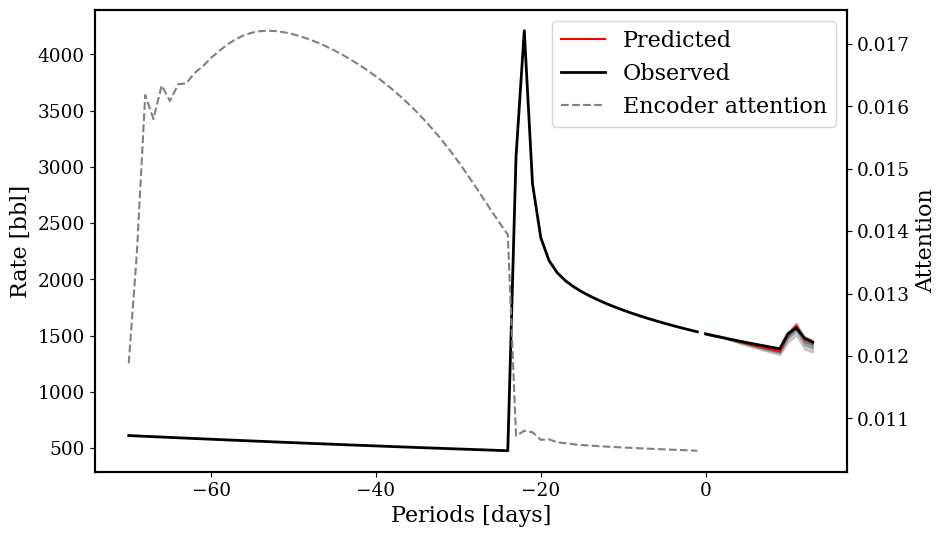

In [39]:
make_plot(x,raw_prediction,idx=0)

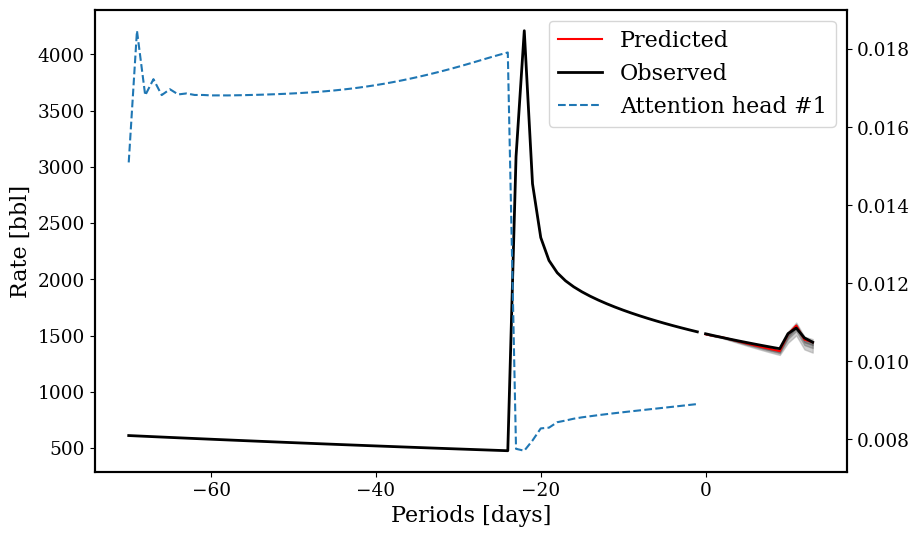

In [40]:
make_plot_separate_att(x,raw_prediction,idx=0)

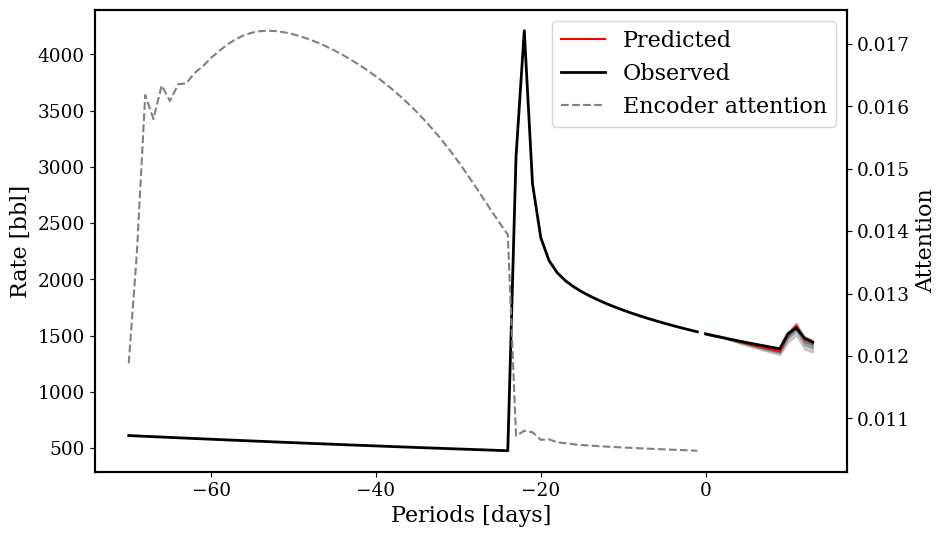

In [41]:
make_test_plot_quantiles(x,raw_prediction,idx=0)

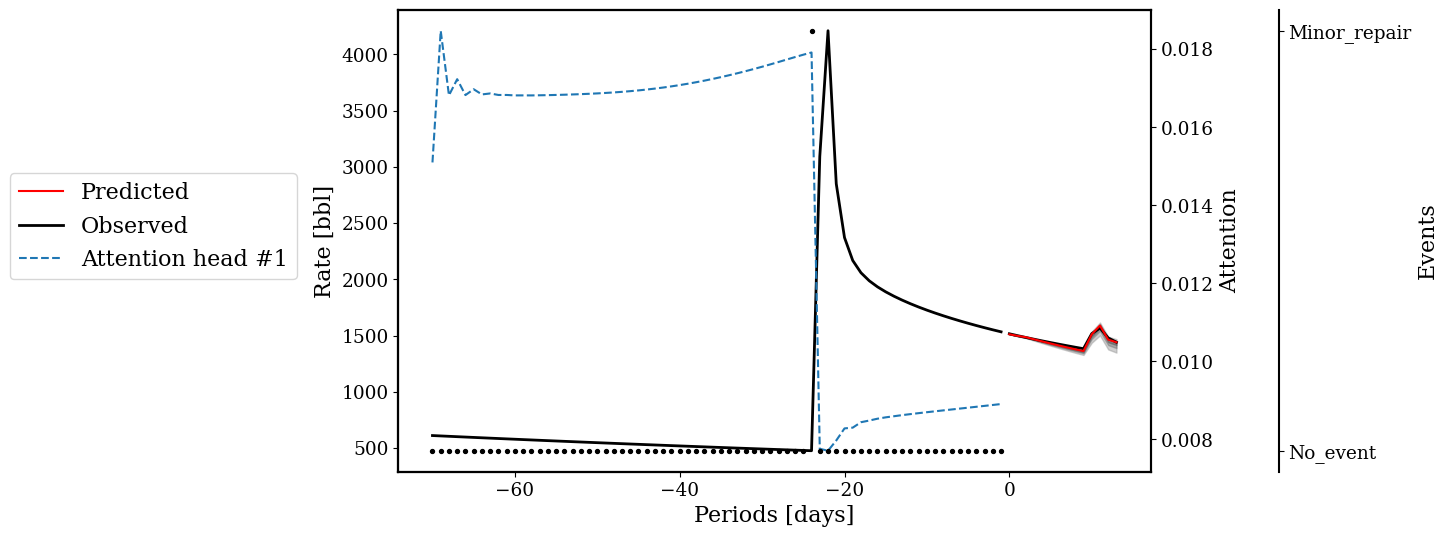

In [42]:
events = return_events(data,Well,prediction_time)
make_plot_separate_att_with_events(x,raw_prediction,events)

Testing

In [43]:
data.time_idx.max(),training_cutoff

(1094, 914)

In [44]:
prediction_time = 1000
Well = 7

The model was trained using 0 to 914, then we include all the steps using the same function from above so the dataset goes from 0 to 1094 steps and predict from step 914 which corresponds to testing data

In [45]:
training = TimeSeriesDataSet(data,
    time_idx="time_idx",
    target="rate",
    group_ids=['well'],
    min_encoder_length=max_encoder_length // 2,
    max_encoder_length=max_encoder_length,
    min_prediction_length=1,
    max_prediction_length=max_prediction_length,
    static_reals=['posx','posy'],
    time_varying_known_reals=['poro','perm'],
    time_varying_unknown_reals=["rate",
         "feat_kh",
         "feat_phih",],
    time_varying_known_categoricals=['operation']
)

In [46]:
raw_prediction, x = best_tft.predict(
    training.filter(lambda x: (x.well == Well) & (x.time_idx_first_prediction == prediction_time)),
    mode="raw",
    return_x=True,
)

We use a testing period at 1000 days for Well #7. We pass an event and the TFT predicts a jump in the predicted rate.

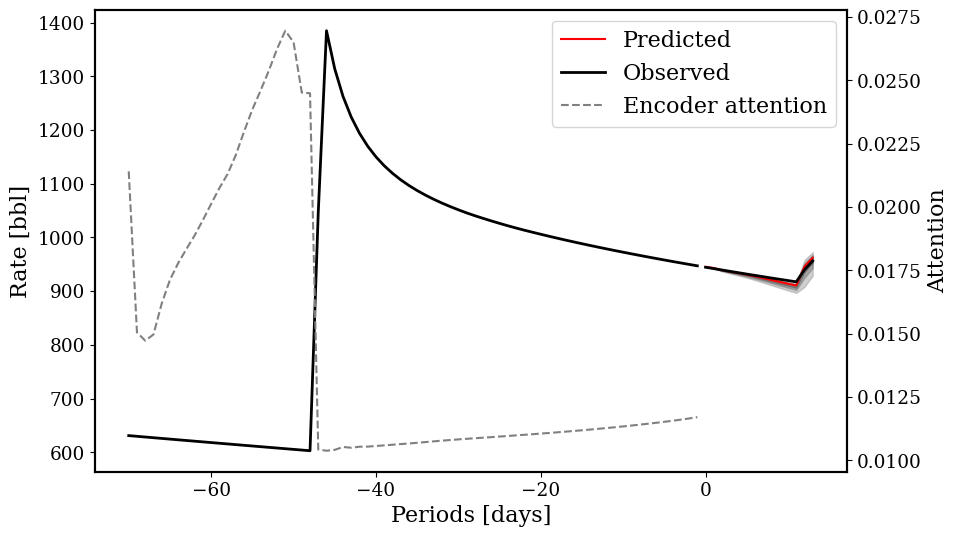

In [47]:
make_plot(x,raw_prediction,idx=0)

## Prediction loop generator

Special attention to step 1000. The model predicts the jump in oil production based on the input to the decoder. Highest attention goes to the event

990


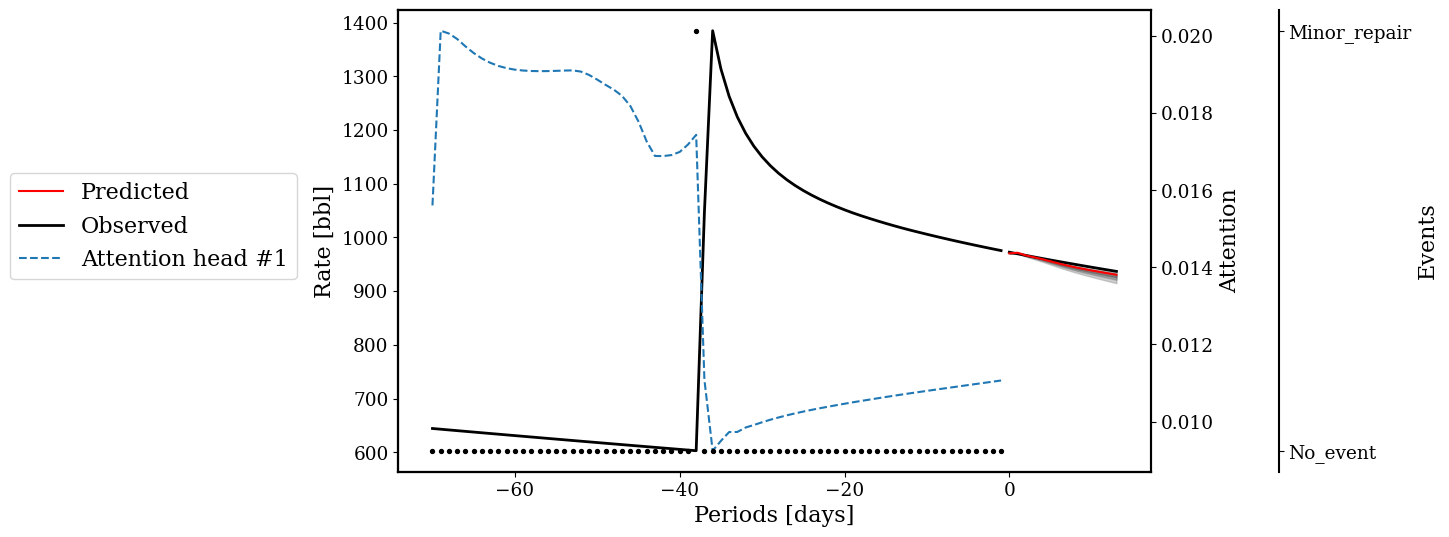

991


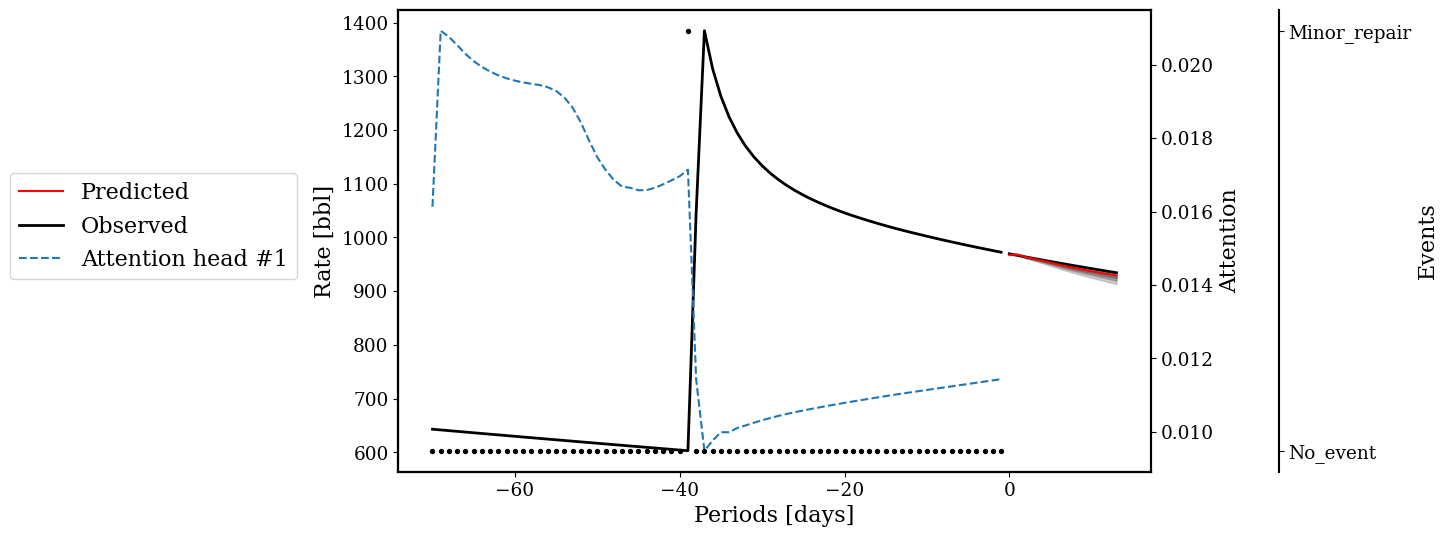

992


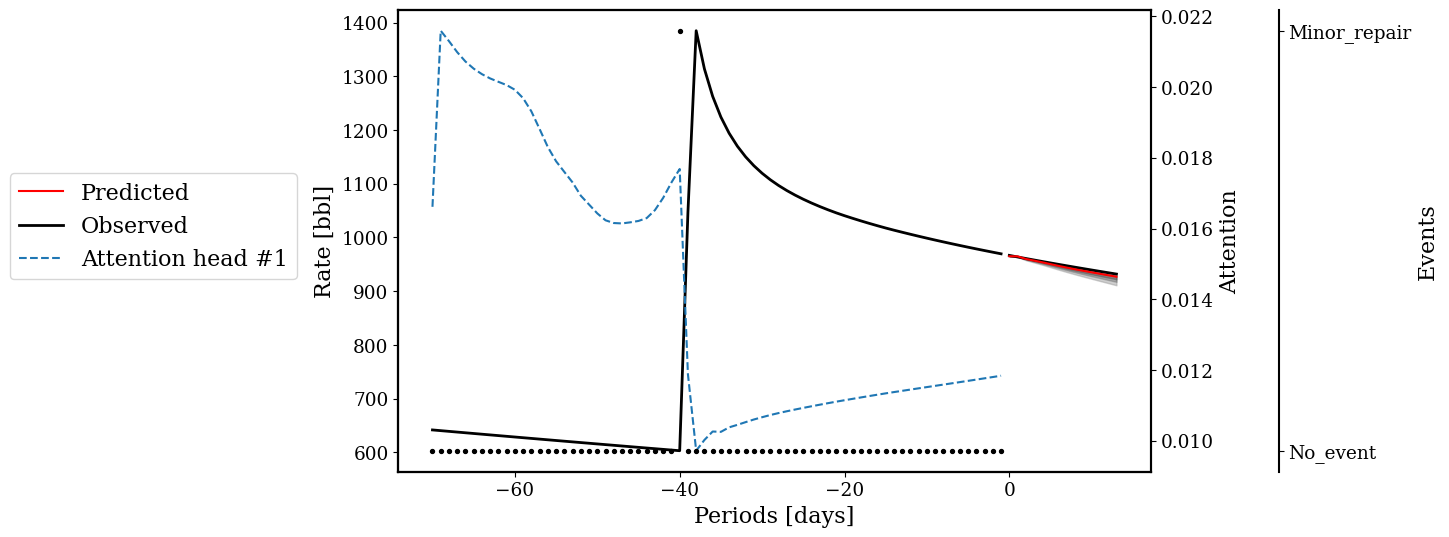

993


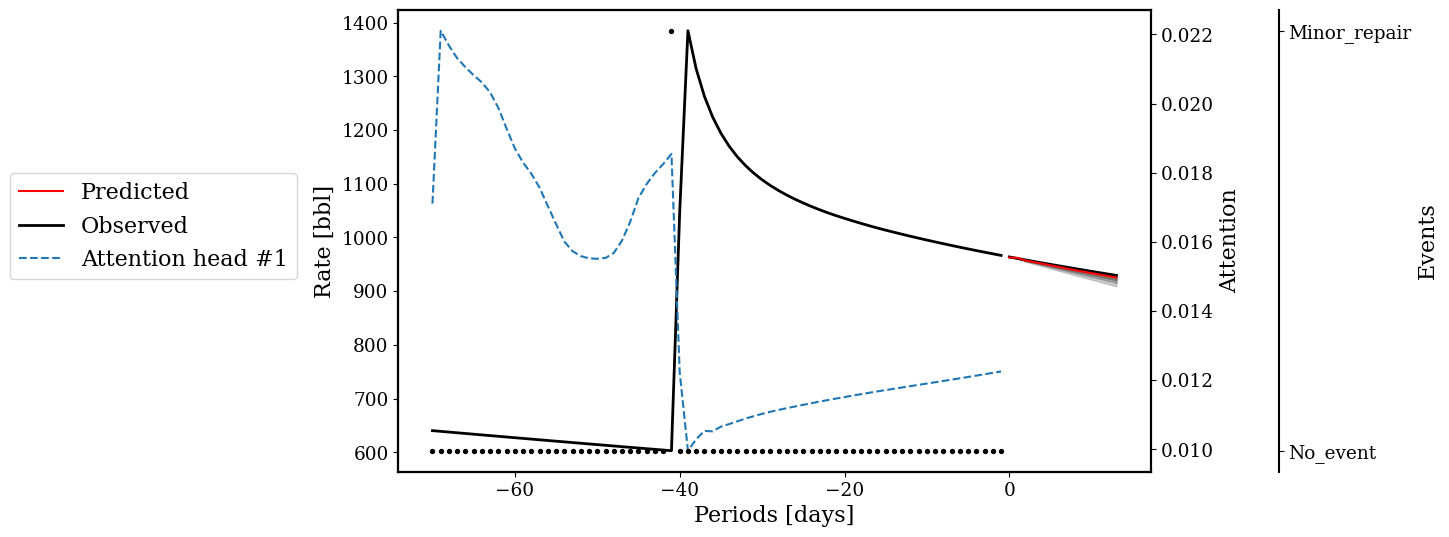

994


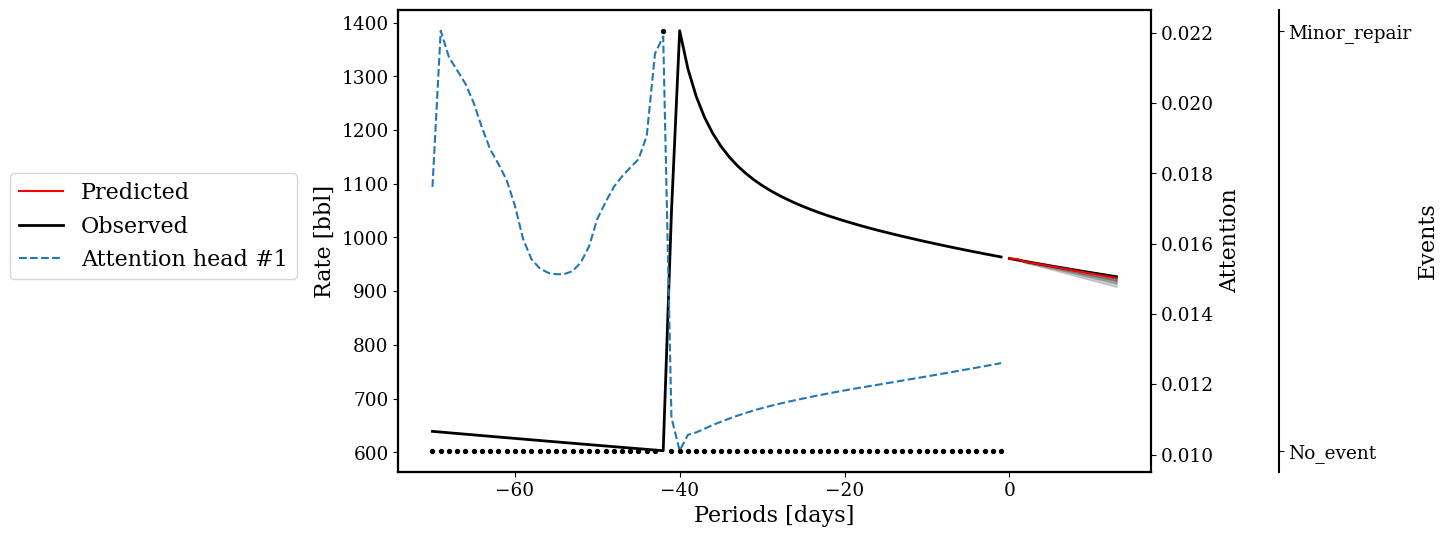

995


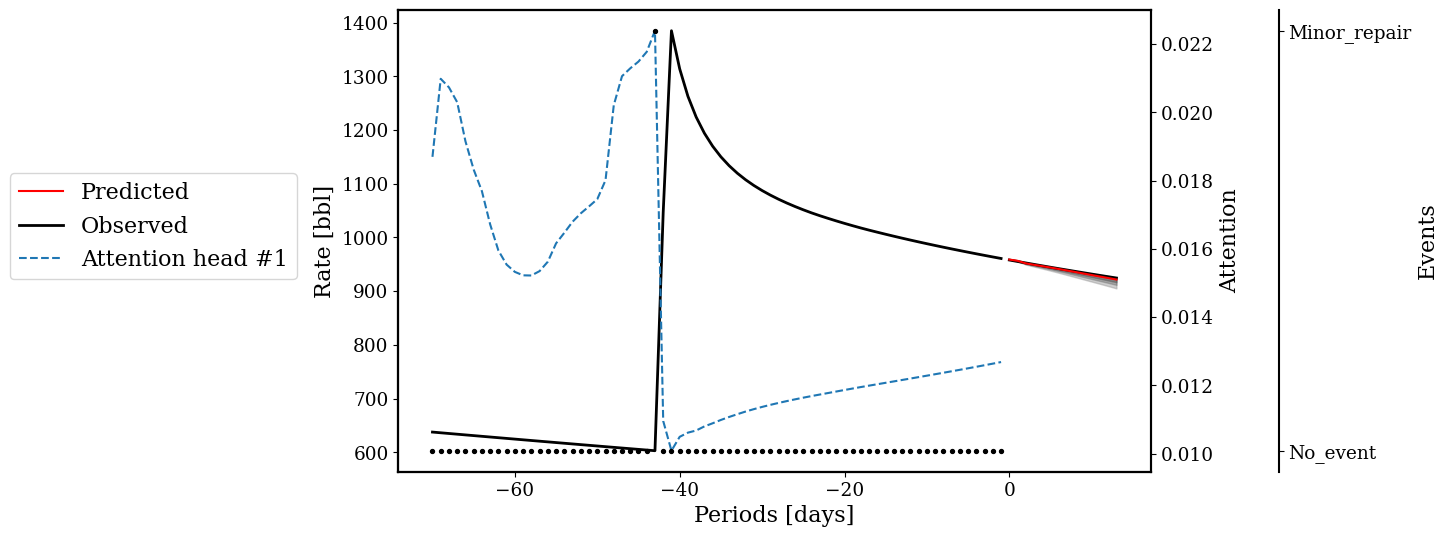

996


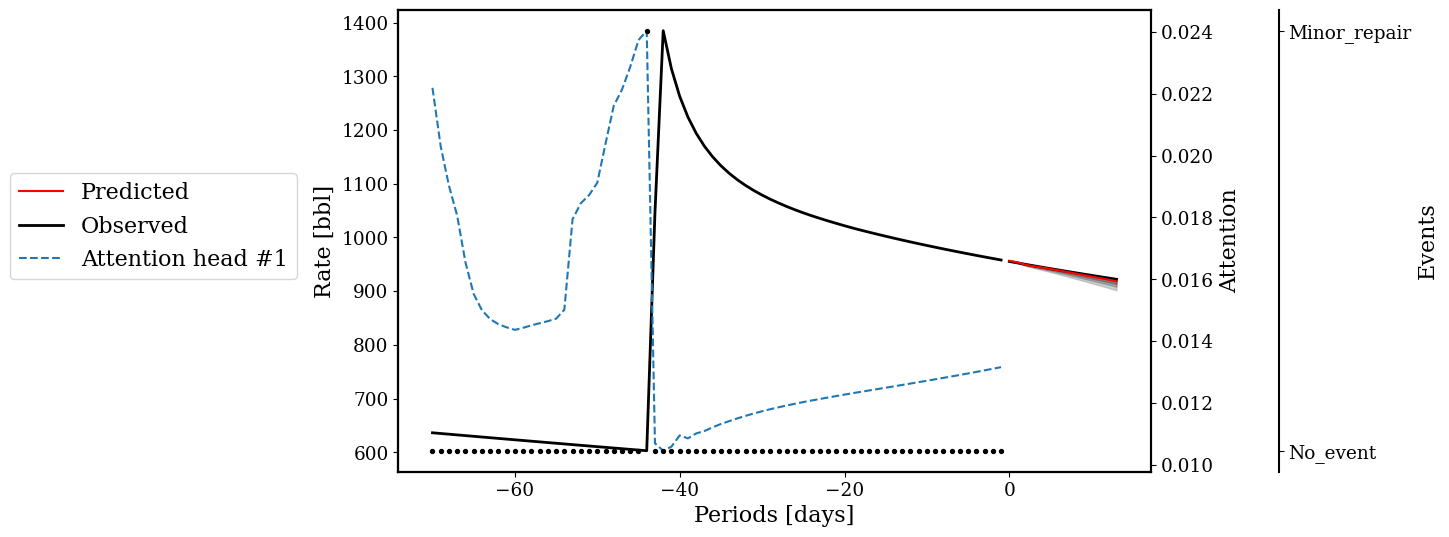

997


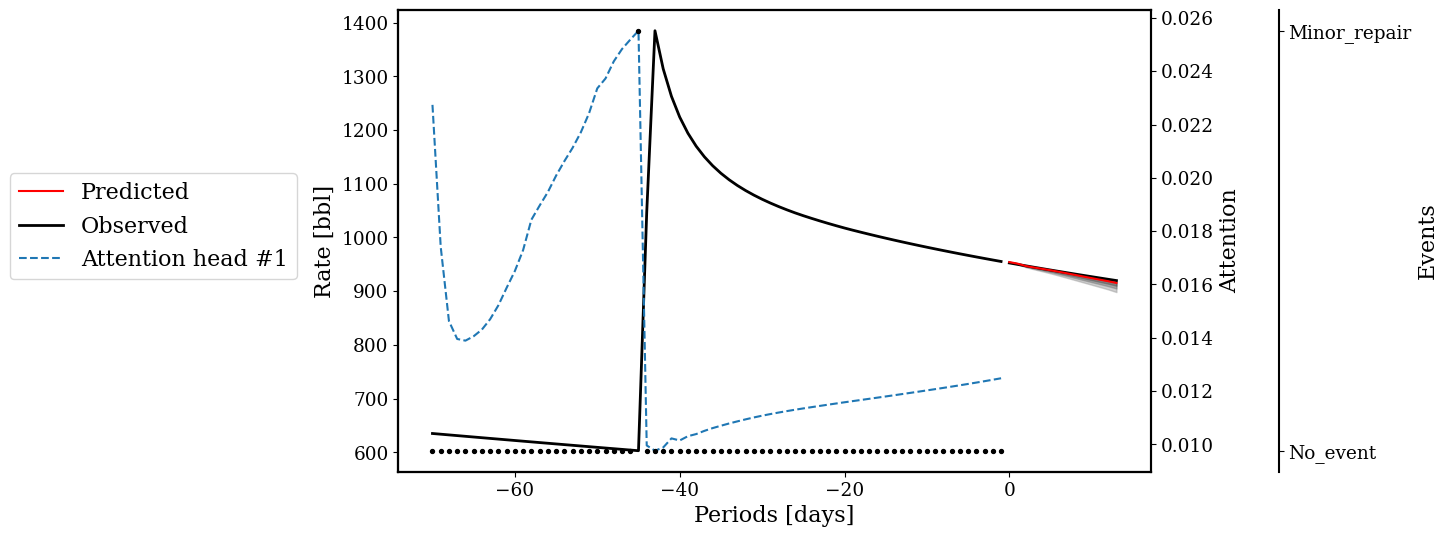

998


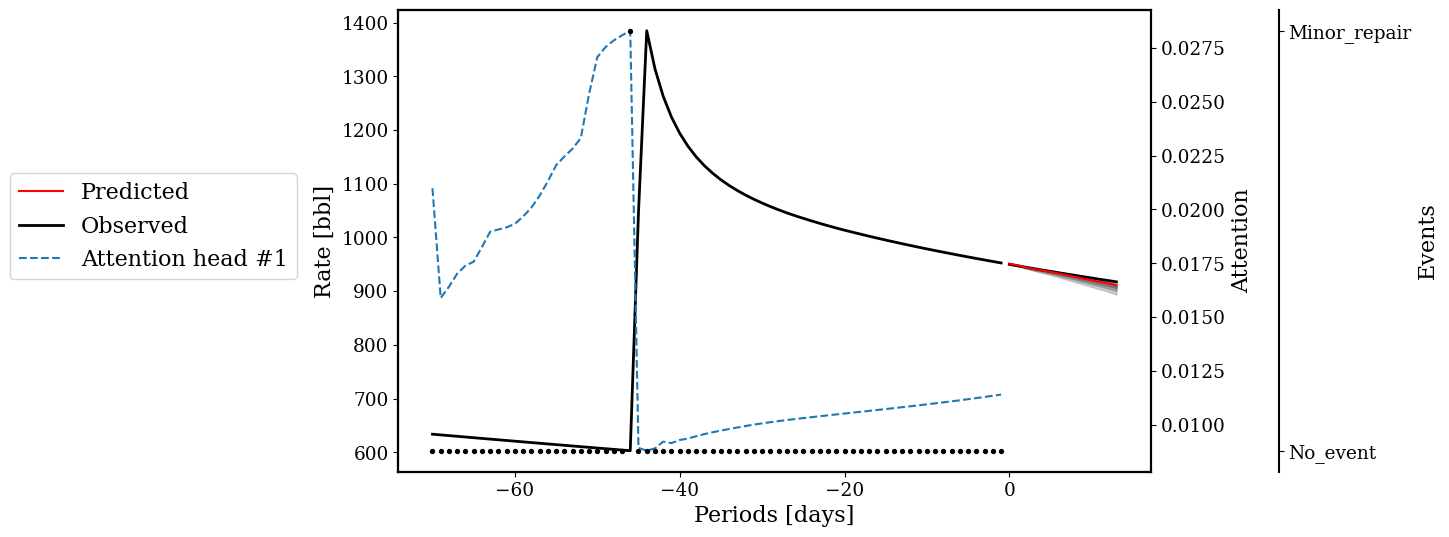

999


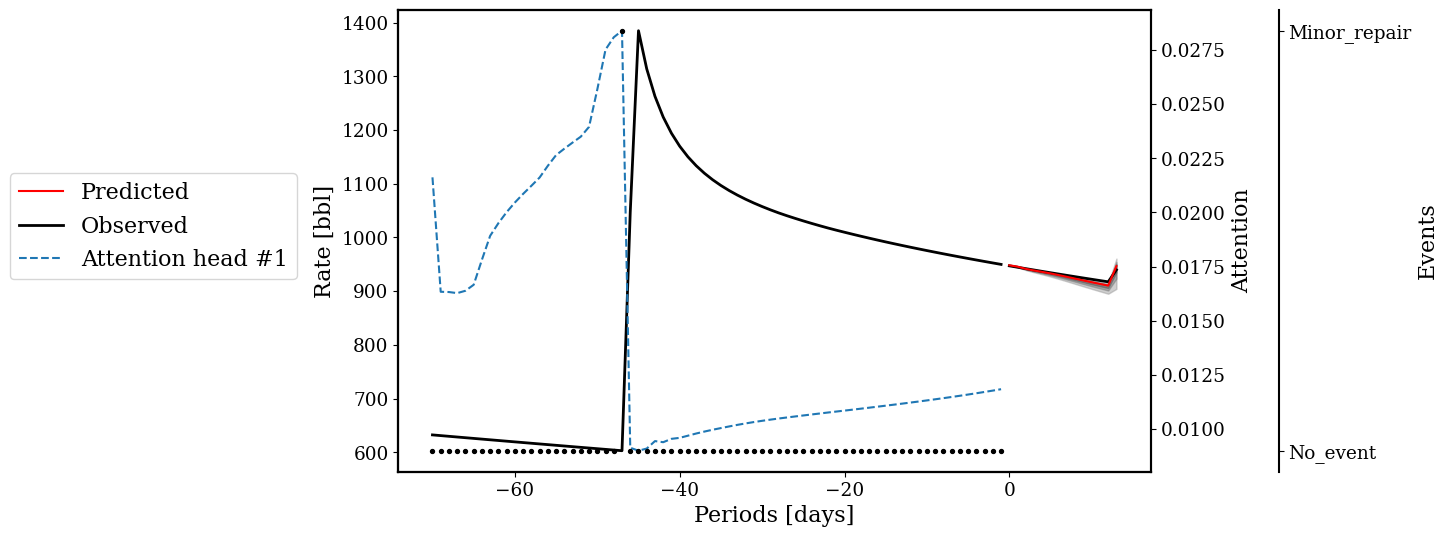

1000


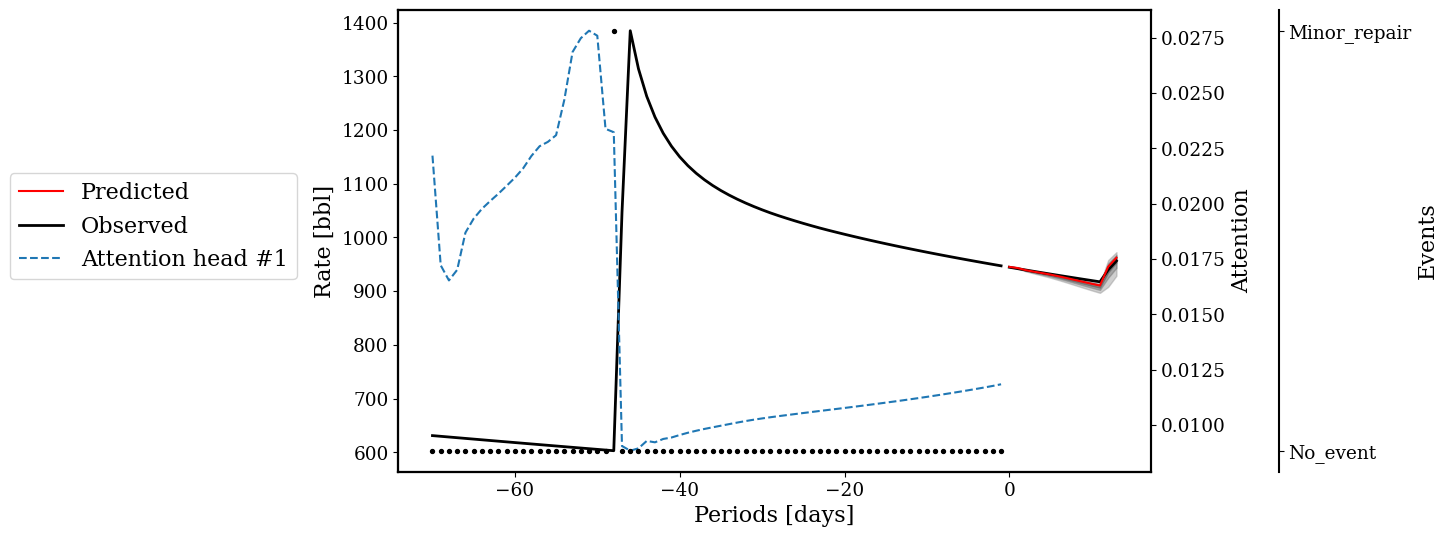

1001


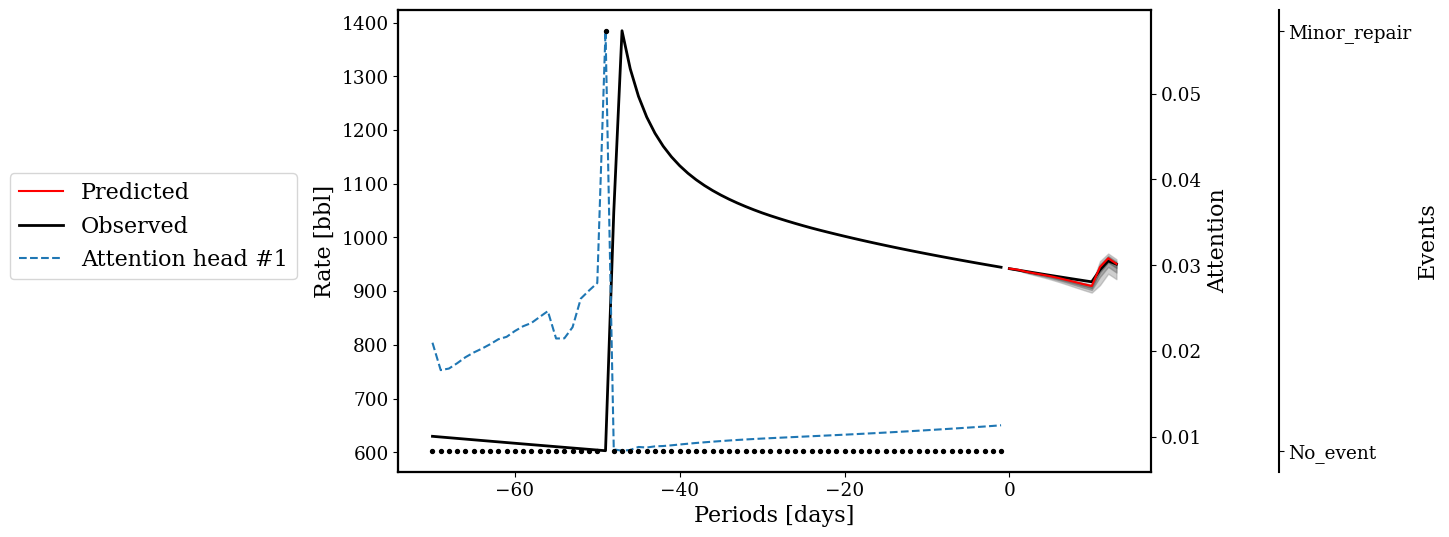

1002


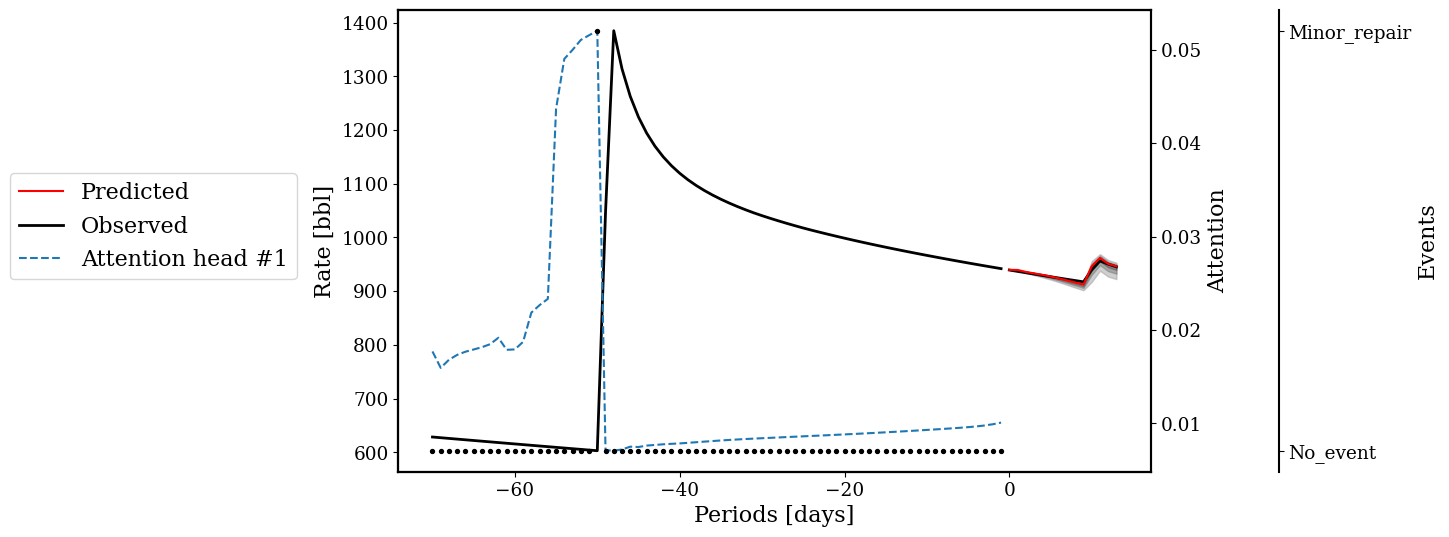

1003


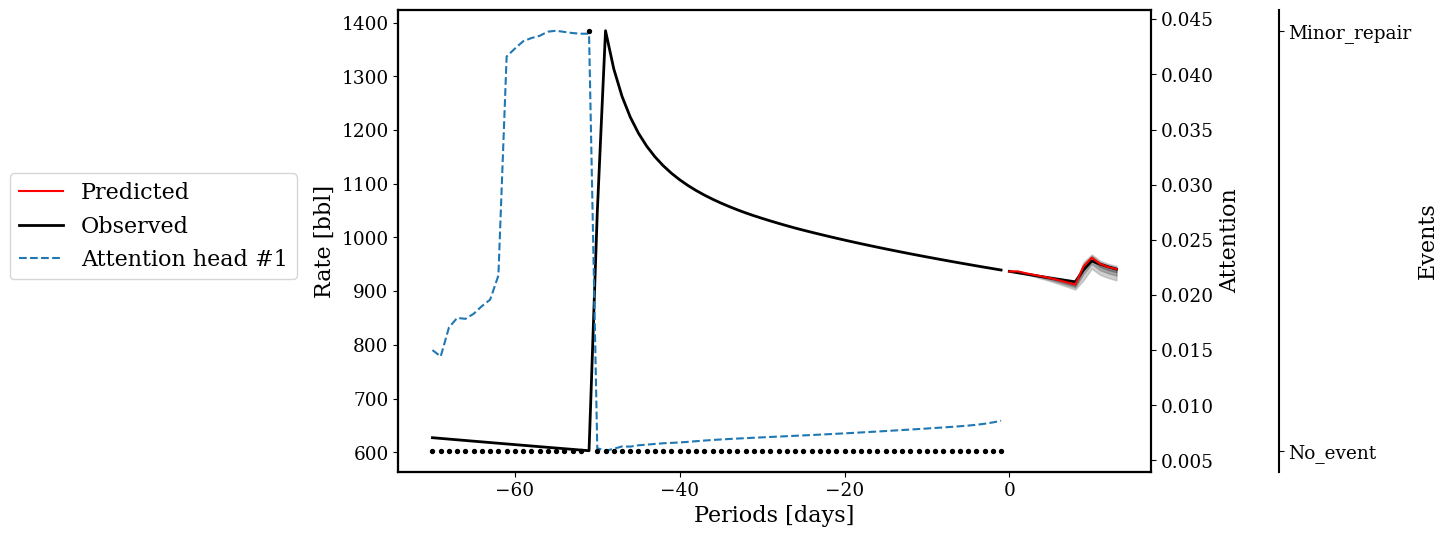

1004


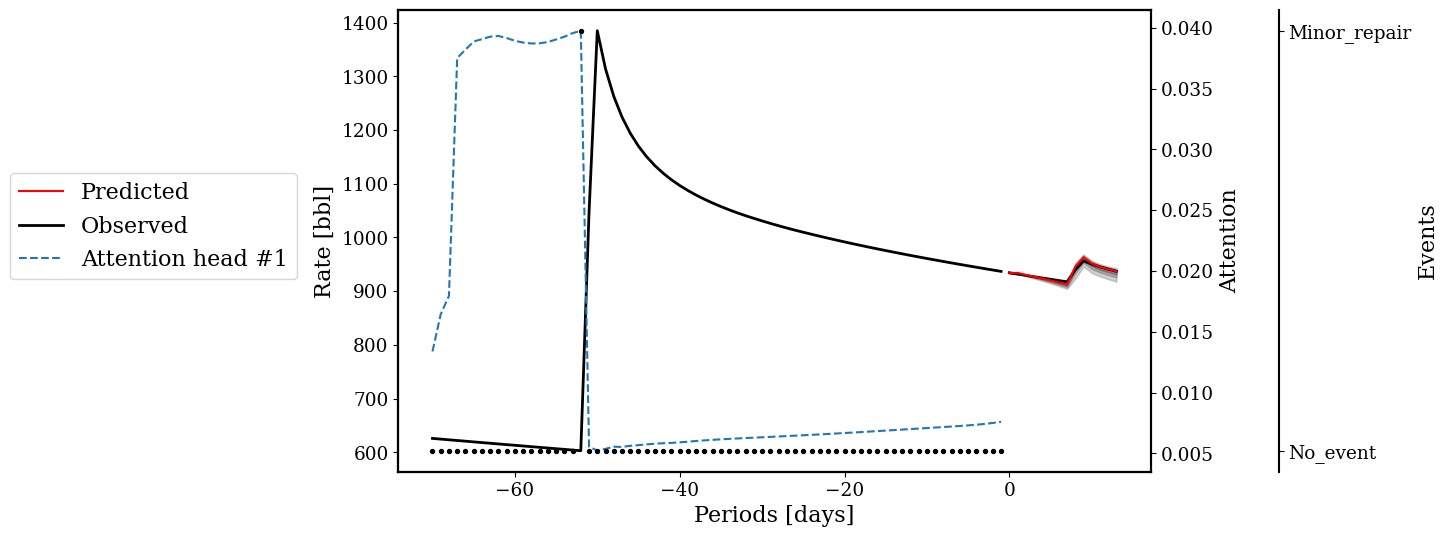

1005


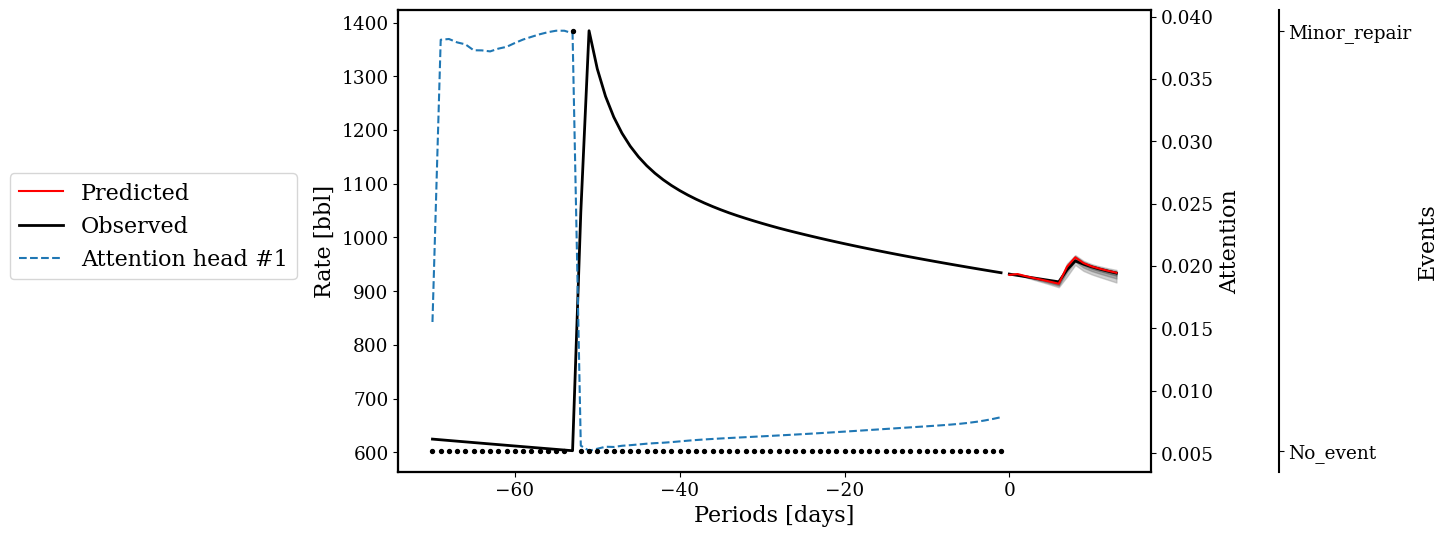

1006


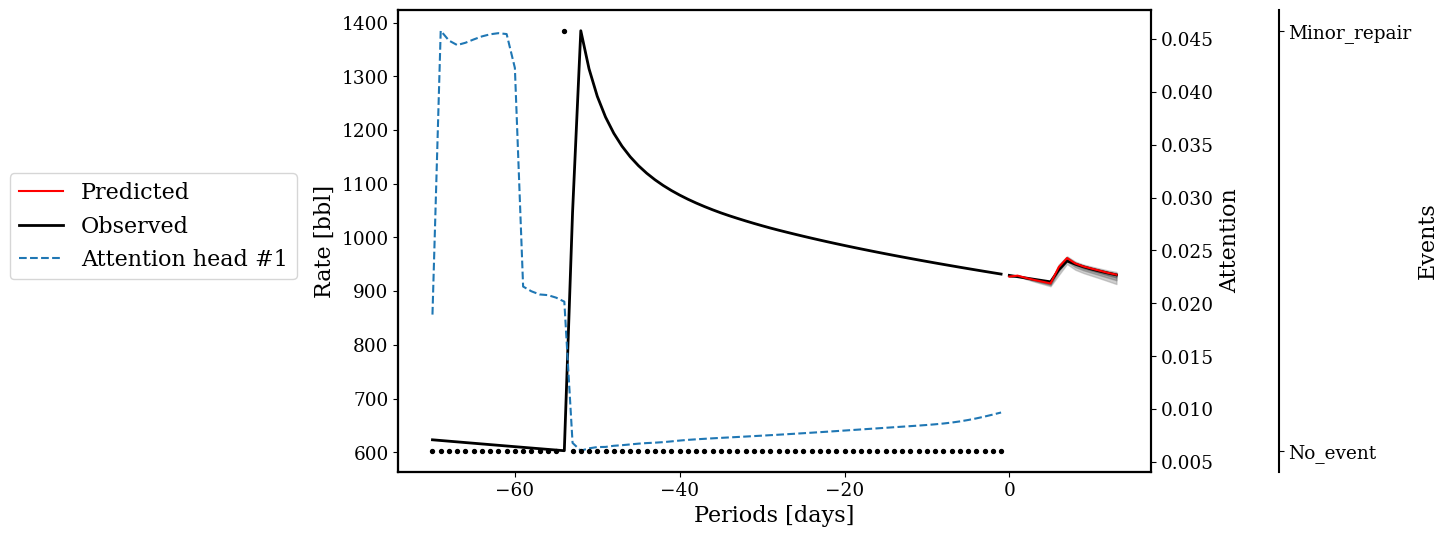

1007


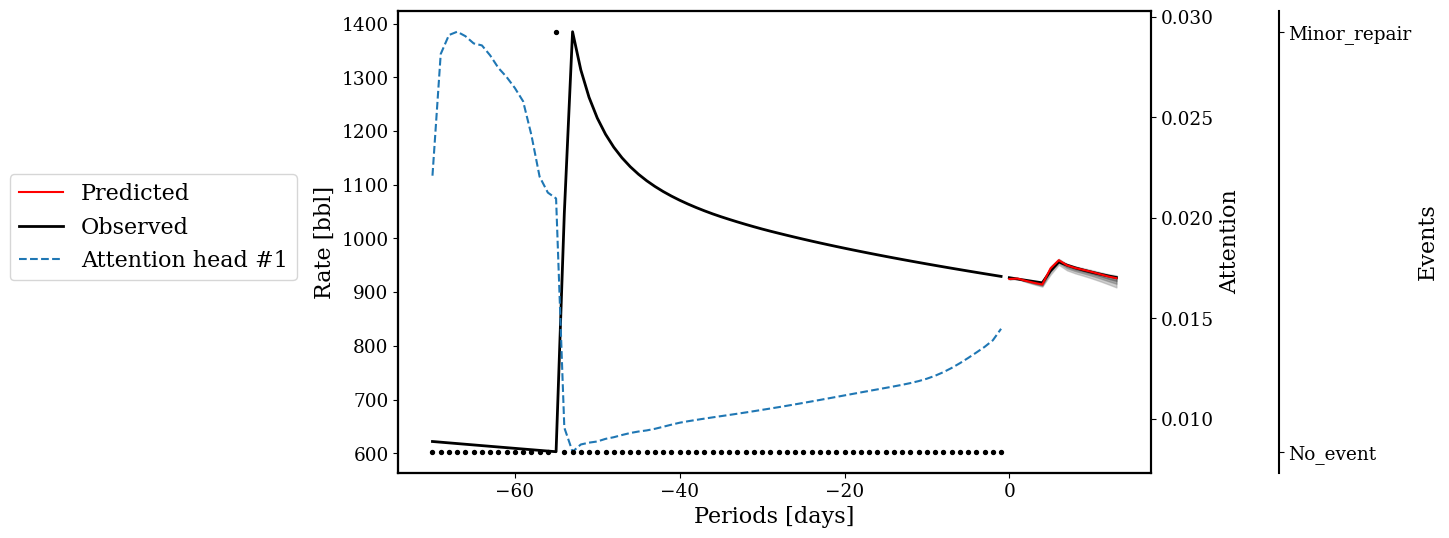

1008


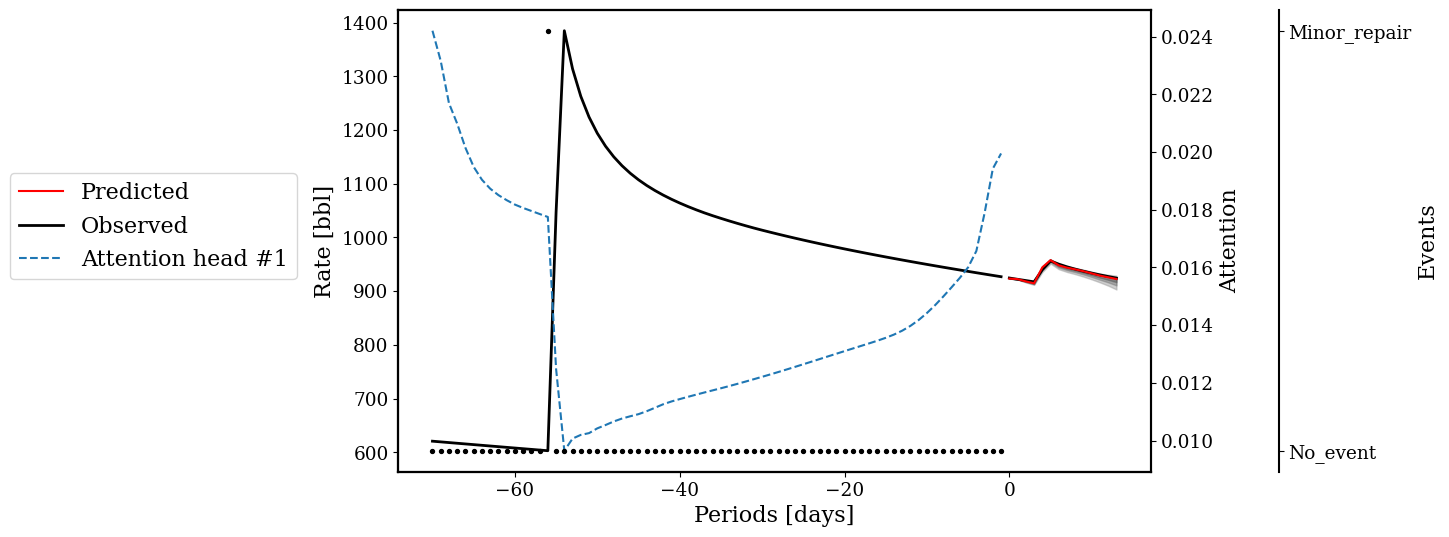

1009


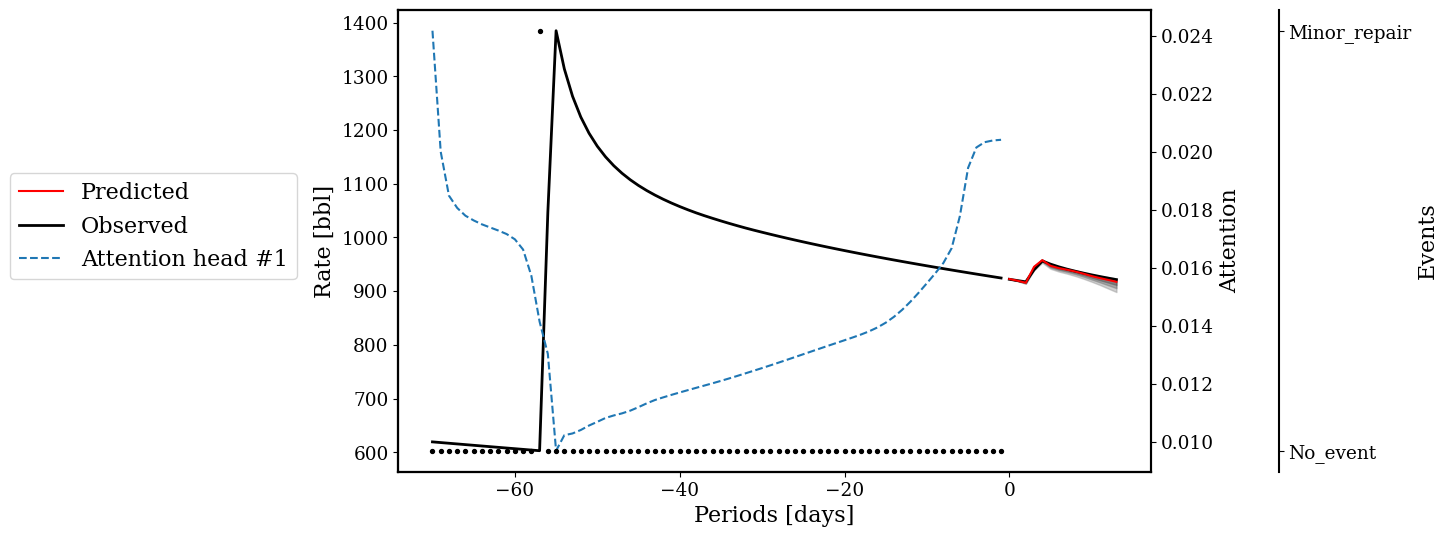

In [48]:
#times = np.arange(900,1067,1)
times = np.arange(990,1010,1) # 550,700

for time in times:
    print(time)
    raw_prediction, x = best_tft.predict(
    training.filter(lambda x: (x.well == Well) & (x.time_idx_first_prediction == time)),
    mode="raw",
    return_x=True,)
    
    events = return_events(data,Well,time)
    make_plot_separate_att_with_events(x,raw_prediction,events)


## Plot 140 days of production forecasting in the testing dataset

In [49]:
#Well = 0 
predictions_array = np.zeros([140,14,7])
true_values = np.zeros([140,14])
for i in range(0,140):
    raw_prediction, x = best_tft.predict(
    training.filter(lambda x: (x.well == Well) & (x.time_idx_first_prediction == i+914)),
    mode="raw",
    return_x=True,
)
    #predictions.append(raw_prediction['prediction'][0,:,3])
    predictions_array[i,:,:] = raw_prediction['prediction'][0,:,:]
    true_values[i,:]=x['decoder_target'][0,:]
    

In [50]:
predictions_array_new = np.zeros([predictions_array.shape[0],predictions_array.shape[0]+predictions_array.shape[1],7],)
predictions_array_new[:] = np.nan
for i in range(predictions_array.shape[0]):
     #if i<=predictions_array.shape[0]-predictions_array.shape[1]:
    predictions_array_new[i,i:(predictions_array.shape[1]+i)] = predictions_array[i,:]
predictions_array_summary = np.nanmean(predictions_array_new,0)

Text(0.5, 0, 'Time [days]')

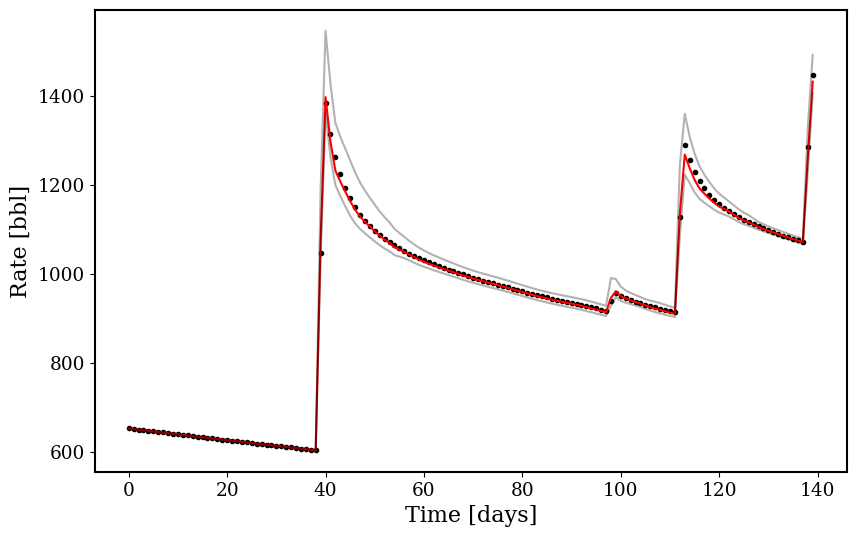

In [51]:
fig, ax = plt.subplots()

ax.plot(np.arange(0,140),data[data.well==Well].rate[914:914+140],'k.')
ax.plot(np.arange(0,140,1),predictions_array_summary[:140,3],'r-',label = 'Predicted values')
ax.plot(np.arange(0,140,1),predictions_array_summary[:140,1],'k-',alpha=0.3,label = 'P10')
ax.plot(np.arange(0,140,1),predictions_array_summary[:140,6],'k-',alpha=0.3,label = 'P90')

ax.set_ylabel('Rate [bbl]')
ax.set_xlabel('Time [days]')

## Encoder - Decoder attention plots

In [52]:
def make_plot_decoder(x,out,events,encoder_variables):
# all true values for y of the first sample in batch
    idx=0

    #out = raw_predictions

    encoder_target = x["encoder_target"]
    decoder_target = x["decoder_target"]

    y_raw = out["prediction"]  # raw predictions - used for calculating loss
    y_hat = out['prediction']
    y_quantile = out['prediction'] # quantiles of shape batch_size x timesteps x n_quantiles

    y_all = torch.cat([encoder_target[0], decoder_target[0]])

    max_encoder_length = x["encoder_lengths"].max()

    y = torch.cat((y_all[: x["encoder_lengths"][idx]],
                   y_all[max_encoder_length : (max_encoder_length + x["decoder_lengths"][idx])]))

    y_hat = y_hat.detach().cpu()[idx, : x["decoder_lengths"][idx]]
    y_quantile = y_quantile.detach().cpu()[idx, : x["decoder_lengths"][idx]]
    
    #Added
    qresiduals = return_qresiduals(out)
    y_quantile = return_quantiles(out,Weights_neg,Weights_pos,return_p50(y_hat),qresiduals)
    
    y_raw = y_raw.detach().cpu()[idx, : x["decoder_lengths"][idx]]

    y = y.detach().cpu()
    n_pred = y_hat.shape[0]
    x_obs = np.arange(-(y.shape[0] - n_pred), 0)
    x_pred = np.arange(n_pred)
    

    fig,ax = plt.subplots()
    
    for i in range(y_quantile.shape[1] // 2):
        if len(x_pred) > 1:
            ax.fill_between(x_pred, y_quantile[:, i], y_quantile[:, -i - 1], alpha=0.45,color = color[i])
        else:
            quantiles = torch.tensor([[y_quantile[0, i]], [y_quantile[0, -i - 1]]])
            ax.errorbar(x_pred, y[[-n_pred]], yerr=quantiles - y[-n_pred], capsize=1.0)

    
    lns2 = ax.plot(x_obs, y[:-n_pred], label="Observed", c='black',linewidth=2)
    ax.plot(x_pred, y[-n_pred:], c='black',linewidth=2)
    lns1 = ax.plot(x_pred, return_p50(y_hat), label="Predicted", c = 'red')
    
    
    ax.set_ylabel('Rate [bbl]')
    ax.set_xlabel('Periods [days]')
    
    ## For second axis
    ax2 = ax.twinx()
    
    
    ax2.plot(x_obs, raw_prediction['encoder_attention'][0, 0, 0, :],'--', label=f'Encoder attention {encoder_variables[i]}')
    ax2.plot(x_obs, raw_prediction['encoder_attention'][0, 0, 1, :],'--', label=f'Encoder attention {encoder_variables[i]}')
    
#     lns3 = ax2.plot(x_obs,
#          raw_prediction['encoder_attention'][0, 0, 0, :],'--',
#          label='Encoder attention head #1')
#     lns4 = ax2.plot(x_obs,
#              raw_prediction['encoder_attention'][0, 0, 1, :],'--',
#              label='Encoder attention head #2')
    
#     lns3 = ax2.plot(x_pred,raw_predictions['decoder_attention'][0, 0, 0, :],'--',
#          label='Decoder attention head #1')
    
#     lns4 = ax2.plot(x_pred,raw_predictions['decoder_attention'][0, 0, 1, :],'--',
#          label='Decoder attention head #2')
    
    ax2.set_ylabel('Attention')
    
    ## For third axis
    ax3 = ax.twinx()
    ax3.spines.right.set_position(('axes',1.17)) #Separation to second axis
    ax3.scatter(x_obs,events,marker = 'o',color='green', s=8, alpha = 0.55)
    ax3.set_ylabel('Events')
    
    ## Legends
    
    #lns = lns1 + lns2 + lns3 + lns4
    #labs = [l.get_label() for l in lns]
    ax.legend(encoder_variables, loc=0, bbox_to_anchor=(-0.12,0.67))
    
#     if savefigs==True:
#         plt.savefig('')
    
    plt.show()

In [53]:
x_obs = np.arange(0,70,1)
x_pred = np.arange(70,84,1)

Define the prediction time and well to perform the prediction, and then obtain the raw outputs from the TFT

In [54]:
prediction_time = 1000
Well = 7

In [55]:
raw_prediction, x = best_tft.predict(
    training.filter(lambda x: (x.well == Well) & (x.time_idx_first_prediction == prediction_time)), 
    mode="raw",
    return_x=True,
)

Normalize the attentions

In [56]:
Encoder_attention = np.average(raw_prediction['encoder_attention'][0,:,:,:],axis=0)
Decoder_attention = np.average(raw_prediction['decoder_attention'][0,:,:,:],axis=0)

In [57]:
Encoder_attention_n = Encoder_attention / np.sqrt(np.sum(Encoder_attention**2))
Decoder_attention_n = Decoder_attention / np.sqrt(np.sum(Decoder_attention**2))

Return the events and properties from the training dataset at the selected prediction time

In [58]:
events = return_events(data,Well,prediction_time-1)
porosity_en = return_porosity_en(data,Well,prediction_time)
permeability_en = return_permeability_en(data,Well,prediction_time)

porosity_de = return_porosity_de(data,Well,prediction_time)
permeability_de = return_permeability_de(data,Well,prediction_time)
events_de = return_events_de(data,Well,prediction_time-1)

### Figures with attention heads

The following figure shows a prediction time and then repeat the plot including the attention heads for this period

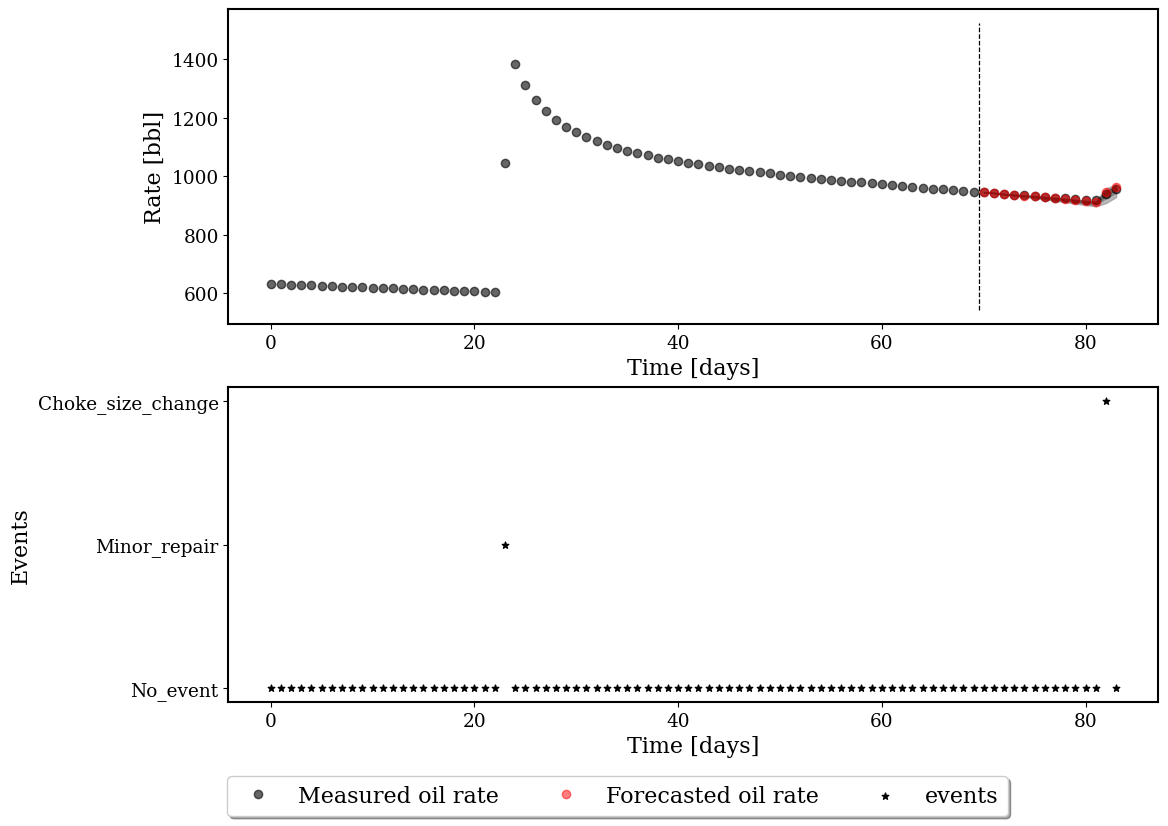

In [59]:
minval = min(x['decoder_target'].cpu().numpy().min(),x['encoder_target'].cpu().numpy().min())
maxval = max(x['decoder_target'].cpu().numpy().max(),x['encoder_target'].cpu().numpy().max())

figures= []
fig, axs = plt.subplots(2,1,figsize=(12,9))
ax = axs[0]
figures.append(ax.plot(x_obs,x['encoder_target'][0,:],'ko',label = 'Measured oil rate',alpha=0.6)[0])
ax.plot(x_pred,x['decoder_target'][0,:],'ko',alpha=0.6) #For well 0

ax.set_ylabel('Rate [bbl]')
ax.set_xlabel('Time [days]')
ax.plot([x_pred[0]-0.5,x_pred[0]-0.5],[minval*0.9,maxval*1.1],'k--',linewidth=0.9)

y_quantile = raw_prediction['prediction'] # quantiles of shape batch_size x timesteps x n_quantiles
y_quantile = y_quantile.detach().cpu()[0, : x["decoder_lengths"][0]]
qresiduals = return_qresiduals(raw_prediction)
y_quantile = return_quantiles(raw_prediction,Weights_neg,Weights_pos,return_p50(raw_prediction['prediction'][0,:]),qresiduals)

figures.append(ax.plot(x_pred, return_p50(raw_prediction['prediction'][0,:]), 'ro', label="Forecasted oil rate",alpha = 0.5)[0])
for i in range(y_quantile.shape[1] // 2):
    if len(x_pred) > 1:
        ax.fill_between(x_pred, y_quantile[:, i], y_quantile[:, -i - 1], alpha=0.65,color = color[i])
    else:
        quantiles = torch.tensor([[y_quantile[0, i]], [y_quantile[0, -i - 1]]])
        ax.errorbar(x_pred, y[[-n_pred]], yerr=quantiles - y[-n_pred], capsize=1.0)

ax2 = axs[1]

figures.append(ax2.scatter(x_obs,events,marker = '*',color='black', s=24, label='events', linestyle='None'))
ax2.scatter(x_pred,events_de,marker = '*',color='black', s=24, linestyle='None')
ax2.set_ylabel('Events')
ax2.set_xlabel('Time [days]')

labels = [l.get_label() for l in figures]
ax.legend(figures,labels,bbox_to_anchor=(0.85, -1.4),shadow = True,ncols=5)

#plt.savefig('Figure_9-We_use_the_last_180_days_of_production_history.png',dpi=300)

Now including the attention heads

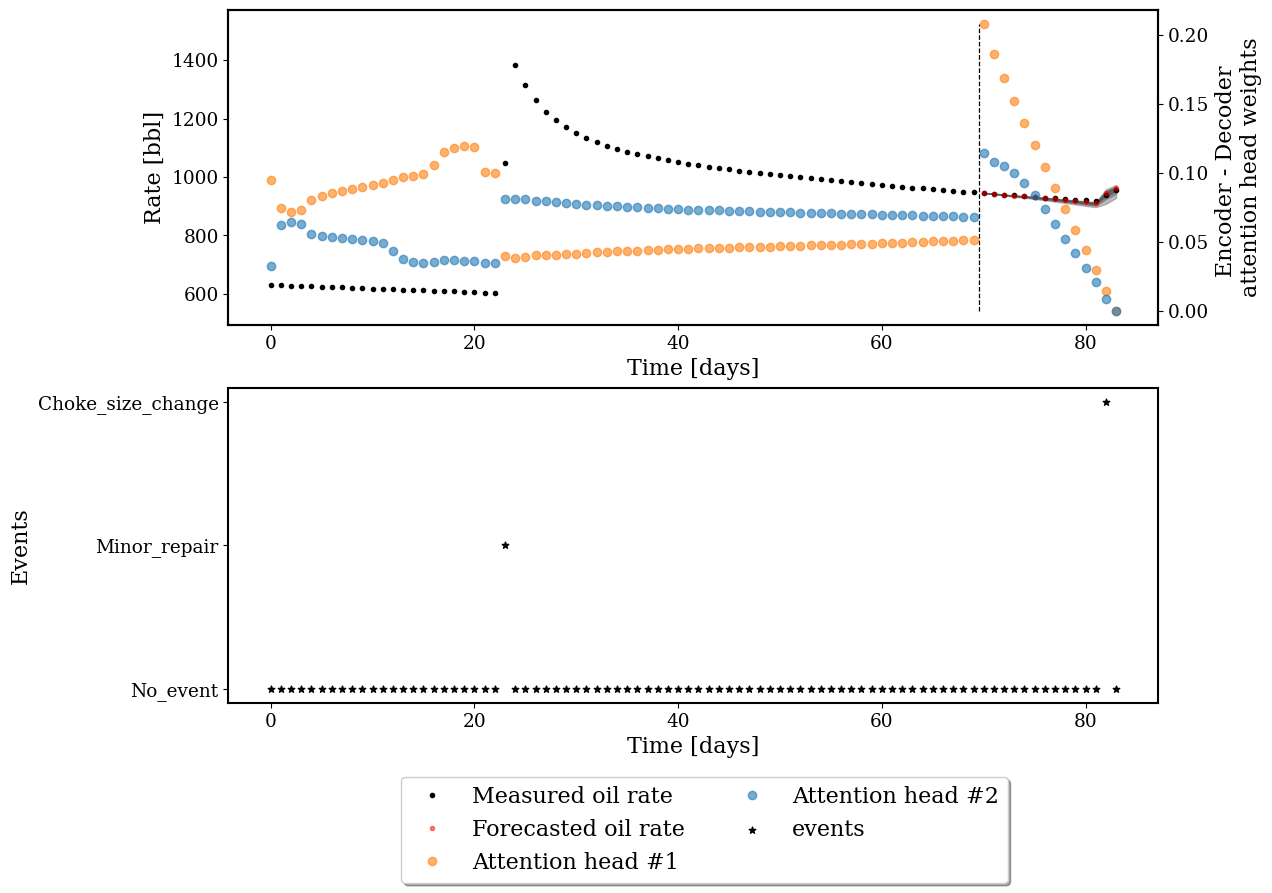

In [60]:
figures= []
fig, axs = plt.subplots(2,1,figsize=(12,9))

ax = axs[0]
figures.append(ax.plot(x_obs,x['encoder_target'][0,:],'k.',label = 'Measured oil rate')[0])
ax.plot(x_pred,x['decoder_target'][0,:],'k.') #For well 0
ax.set_ylabel('Rate [bbl]')
ax.set_xlabel('Time [days]')
ax.plot([x_pred[0]-0.5,x_pred[0]-0.5],[minval*0.9,maxval*1.1],'k--',linewidth=0.9)
#ax.set_ylim(1000,2000)

y_quantile = raw_prediction['prediction'] # quantiles of shape batch_size x timesteps x n_quantiles
y_quantile = y_quantile.detach().cpu()[0, : x["decoder_lengths"][0]]
qresiduals = return_qresiduals(raw_prediction)
y_quantile = return_quantiles(raw_prediction,Weights_neg,Weights_pos,return_p50(raw_prediction['prediction'][0,:]),qresiduals)

figures.append(ax.plot(x_pred, return_p50(raw_prediction['prediction'][0,:]), 'r.', label="Forecasted oil rate",alpha = 0.5)[0])
for i in range(y_quantile.shape[1] // 2):
    if len(x_pred) > 1:
        ax.fill_between(x_pred, y_quantile[:, i], y_quantile[:, -i - 1], alpha=0.65,color = color[i])
    else:
        quantiles = torch.tensor([[y_quantile[0, i]], [y_quantile[0, -i - 1]]])
        ax.errorbar(x_pred, y[[-n_pred]], yerr=quantiles - y[-n_pred], capsize=1.0)

#ax.text(30,1800,'Encoder')
#ax.text(72,1800,'Decoder')
#ax.text(-15,2000,'a)')
#ax.text(-15,800,'b)')

ax2 = ax.twinx()
ax2.set_ylabel('Encoder - Decoder \nattention head weights')
figures.append(ax2.plot(x_obs,Encoder_attention_n[0,:],'o',color='tab:orange',label = 'Attention head #1',alpha=0.6)[0])
figures.append(ax2.plot(x_obs,Encoder_attention_n[1,:],'o',color='tab:blue',label = 'Attention head #2',alpha=0.6)[0])
ax2.plot(x_pred,Decoder_attention_n[0,:],'o',color='tab:orange',label = 'Attention head #1',alpha=0.6)
ax2.plot(x_pred,Decoder_attention_n[1,:],'o',color='tab:blue',label = 'Attention head #2',alpha=0.6)
#ax2.set_ylim(0,1)
ax2 = axs[1]
#ax2.spines.right.set_position(('axes',1.20)) #Separation to second axis
figures.append(ax2.scatter(x_obs,events,marker = '*',color='black', s=24, label='events', linestyle='None'))
ax2.scatter(x_pred,events_de,marker = '*',color='black', s=24, linestyle='None')
ax2.set_ylabel('Events')
ax2.set_xlabel('Time [days]')


labels = [l.get_label() for l in figures]
ax.legend(figures,labels,bbox_to_anchor=(0.85, -1.4),shadow = True,ncols=2)

#fig.tight_layout()

#plt.savefig('Figure_10-Production_forecast_with_rate_encoder_decoder.png',dpi=300)

# Interpretability
## Shapley encoder importance

In [61]:
import shap
import xgboost
from xgboost import XGBRegressor

At time 950, we are going to perform Feature importance with SHAP for 100 steps

In [62]:
Well = 1
steps = 1
length = 100
time=950
predictions_array = np.zeros([length,14,7])
true_values = np.zeros([length,14])
importances = np.zeros([length,6])
mutual_information = np.zeros([length,6])
shap_values = np.zeros([length,6])
for i in range(0,length,steps):
    raw_prediction, x = best_tft.predict(
    training.filter(lambda x: (x.well == Well) & (x.time_idx_first_prediction == i+time)),
    mode="raw",
    return_x=True,
)
    #predictions.append(raw_prediction['prediction'][0,:,3])
    predictions_array[i,:,:] = raw_prediction['prediction'][0,:,:]
    true_values[i,:]=x['decoder_target'][0,:]
    
    df=pd.DataFrame()
    df['operation'] =  raw_prediction["encoder_variables"][0,:,0,0]
    df['poro'] =  raw_prediction["encoder_variables"][0,:,0,1]
    df['perm'] =  raw_prediction["encoder_variables"][0,:,0,2]
    df['rate'] =  raw_prediction["encoder_variables"][0,:,0,3]
    df['feat_kh'] =  raw_prediction["encoder_variables"][0,:,0,4]
    df['feat_phih'] = raw_prediction["encoder_variables"][0,:,0,5]
    df['target'] = x['encoder_target'][0,:]

    X = df.iloc[:,[0,1,2,3,4,5]] # separate DataFrames for predictor and response features
    y = df.iloc[:,[6]]

    # xgboost for feature importance on a regression problem
    model = XGBRegressor()
    # fit the model
    model.fit(X, y)
    # get importance
    importances[i,:]=model.feature_importances_
    
    explainer = shap.TreeExplainer(model)
    sp = explainer.shap_values(X)
    sp_vals = np.average(sp,axis=0)
    #sp_vals /= np.max(sp_vals)  
    shap_values[i,:] = sp_vals
    
predictions_array_new = np.zeros([predictions_array.shape[0],predictions_array.shape[0]+predictions_array.shape[1],7],)
predictions_array_new[:] = np.nan
for i in range(predictions_array.shape[0]):
     #if i<=predictions_array.shape[0]-predictions_array.shape[1]:
    predictions_array_new[i,i:(predictions_array.shape[1]+i)] = predictions_array[i,:]
predictions_array_summary = np.nanmean(predictions_array_new,0)

In [63]:
Importance_shapley = np.abs(shap_values.sum(0))
def plot_importance_shapley(title, values, labels):
    fig, ax = plt.subplots(figsize=(7, len(values) * 0.25 + 2))
    order = np.argsort(values)
    values = values / values.sum()
    ax.barh(np.arange(len(values)), values[order], tick_label=np.asarray(labels)[order], color = 'black',alpha = 1)
    ax.set_title(title,fontsize=15)
    ax.set_xlabel("Absolute mean SHAP value")
    plt.tight_layout()
    plt.savefig('Figure_17-Importance_of_encoder_variables.png',dpi=300)

For the selected period, the proposed predictor feature of $\phi h$ is the most important followed by operation and permeability. This plot is a summary of all the 100 steps. However we can plot the importances at every prediction step in the next plot

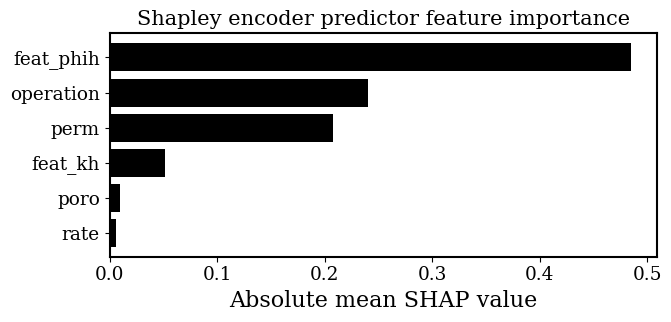

In [64]:
plot_importance_shapley('Shapley encoder predictor feature importance',
                        Importance_shapley,
                        ['rate', 'feat_phih', 'operation', 'poro', 'feat_kh', 'perm'])

For every prediction step we can plot the feature importance. Please note the operation feature

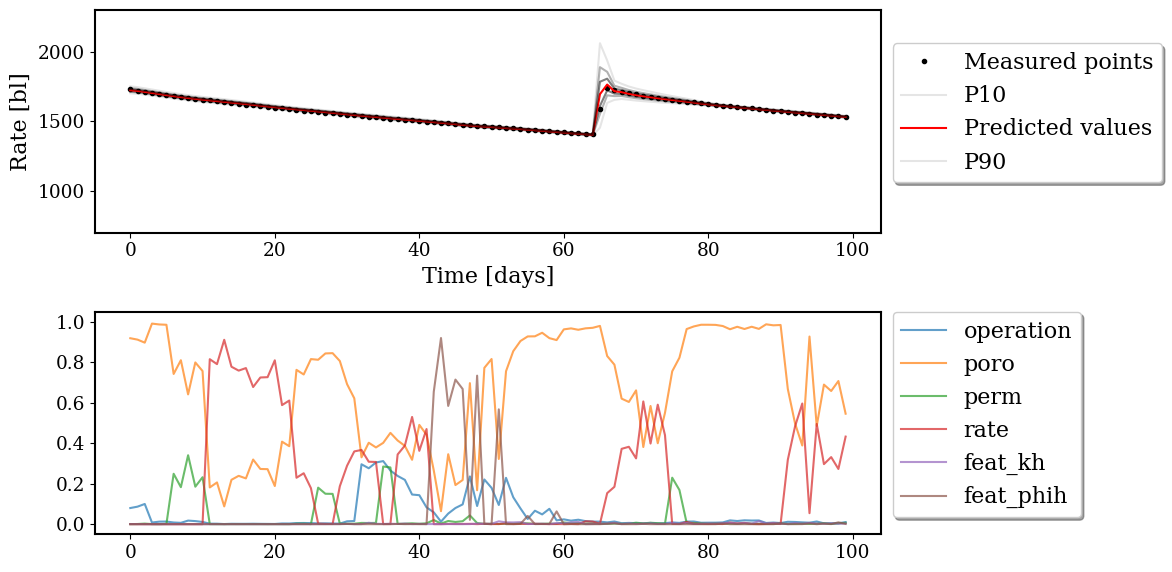

In [65]:
fig, axs = plt.subplots(2,1,figsize=(12,6))

ax=axs[0]
ax.plot(np.arange(0,100),data[data.well==Well].rate[time:time+length],'k.',label='Measured points')
#i=166
#data predicted
ax.plot(np.arange(0,100,steps),predictions_array_summary[:length,0],'k-',alpha=0.1,label='P10')
ax.plot(np.arange(0,100,steps),predictions_array_summary[:length,1],'k-',alpha=0.3)
ax.plot(np.arange(0,100,steps),predictions_array_summary[:length,2],'k-',alpha=0.5)
ax.plot(np.arange(0,100,steps),predictions_array_summary[:length,3],'r-',label = 'Predicted values')
ax.plot(np.arange(0,100,steps),predictions_array_summary[:length,4],'k-',alpha=0.5)
ax.plot(np.arange(0,100,steps),predictions_array_summary[:length,5],'k-',alpha=0.3)
ax.plot(np.arange(0,100,steps),predictions_array_summary[:length,6],'k-',alpha=0.1,label='P90')

#ax.plot([20,20],[500,2300],'k--')
ax.set_ylim(700,2300)
ax.set_ylabel('Rate [bl]')
ax.set_xlabel('Time [days]')
ax.legend(bbox_to_anchor=(1, 0.9),shadow=True)


ax2=axs[1]
#ax2.plot([20,20],[-.5,1.1],'k--')
ax2.plot(np.arange(0,100,steps),importances[:,0],color='tab:blue',label='operation',alpha=0.7)
ax2.plot(np.arange(0,100,steps),importances[:,1],color='tab:orange',label='poro',alpha=0.7)
ax2.plot(np.arange(0,100,steps),importances[:,2],color='tab:green',label='perm',alpha=0.7)
ax2.plot(np.arange(0,100,steps),importances[:,3],color='tab:red',label='rate',alpha=0.7)
ax2.plot(np.arange(0,100,steps),importances[:,4],color='tab:purple',label='feat_kh',alpha=0.7)
ax2.plot(np.arange(0,100,steps),importances[:,5],color='tab:brown',label='feat_phih',alpha=0.7)
ax2.legend(bbox_to_anchor=(1, 1.05),shadow=True)
ax2.set_ylim(-0.05,1.05)

fig.tight_layout()

For every prediction step we can plot the shapley values rather than the absolute mean SHAP value

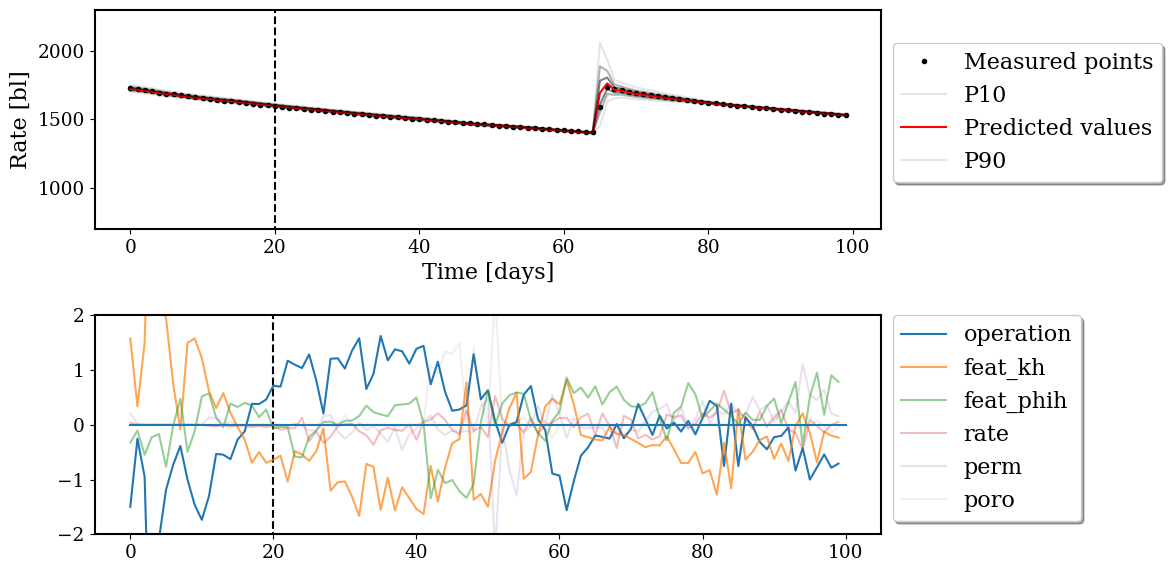

In [66]:
fig, axs = plt.subplots(2,1,figsize=(12,6))

ax=axs[0]
ax.plot(np.arange(0,100),data[data.well==Well].rate[time:time+length],'k.',label='Measured points')
#i=166
#data predicted
ax.plot(np.arange(0,100,1),predictions_array_summary[:length,0],'k-',alpha=0.1,label='P10')
ax.plot(np.arange(0,100,1),predictions_array_summary[:length,1],'k-',alpha=0.3)
ax.plot(np.arange(0,100,1),predictions_array_summary[:length,2],'k-',alpha=0.5)
ax.plot(np.arange(0,100,1),predictions_array_summary[:length,3],'r-',label = 'Predicted values')
ax.plot(np.arange(0,100,1),predictions_array_summary[:length,4],'k-',alpha=0.5)
ax.plot(np.arange(0,100,1),predictions_array_summary[:length,5],'k-',alpha=0.3)
ax.plot(np.arange(0,100,1),predictions_array_summary[:length,6],'k-',alpha=0.1,label='P90')

ax.plot([20,20],[500,2300],'k--')
ax.set_ylim(700,2300)
ax.set_ylabel('Rate [bl]')
ax.set_xlabel('Time [days]')
ax.legend(bbox_to_anchor=(1, 0.9),shadow=True)


ax2=axs[1]
ax2.plot([20,20],[-10,10],'k--')
ax2.plot(np.arange(0,100,1),shap_values[:,0],color='tab:blue',label='operation',alpha=1)
ax2.plot(np.arange(0,100,1),shap_values[:,1],color='tab:orange',label='feat_kh',alpha=0.7)
ax2.plot(np.arange(0,100,1),shap_values[:,2],color='tab:green',label='feat_phih',alpha=0.5)
ax2.plot(np.arange(0,100,1),shap_values[:,3],color='tab:red',label='rate',alpha=0.3)
ax2.plot(np.arange(0,100,1),shap_values[:,4],color='tab:purple',label='perm',alpha=0.2)
ax2.plot(np.arange(0,100,1),shap_values[:,5],color='tab:brown',label='poro',alpha=0.1)
ax2.plot([0,100],[0,0])
ax2.legend(bbox_to_anchor=(1, 1.05),shadow=True)
ax2.set_ylim(-2,2)

fig.tight_layout()

### Shapley decoder importance

In [67]:
x.keys()

dict_keys(['encoder_cat', 'encoder_cont', 'encoder_target', 'encoder_lengths', 'decoder_cat', 'decoder_cont', 'decoder_target', 'decoder_lengths', 'decoder_time_idx', 'groups', 'target_scale'])

In [68]:
x['decoder_cont'].shape

torch.Size([1, 14, 8])

In [69]:
Well = 1
steps = 1
length = 50
time=1000
predictions_array = np.zeros([length,14,7])
true_values = np.zeros([length,14])
importances = np.zeros([length,3])
mutual_information = np.zeros([length,3])
shap_values = np.zeros([length,3])
for i in range(0,length,steps):
    raw_prediction, x = best_tft.predict(
    training.filter(lambda x: (x.well == Well) & (x.time_idx_first_prediction == i+time)),
    mode="raw",
    return_x=True,
)
    #predictions.append(raw_prediction['prediction'][0,:,3])
    predictions_array[i,:,:] = raw_prediction['prediction'][0,:,:]
    true_values[i,:]=x['decoder_target'][0,:]
    
    df=pd.DataFrame()
    df['operation'] =  raw_prediction["decoder_variables"][0,:,0,0]
    df['poro'] =  raw_prediction["decoder_variables"][0,:,0,1]
    df['perm'] =  raw_prediction["decoder_variables"][0,:,0,2]
    df['target'] = raw_prediction['prediction'][0,:,-1]
    X = df.iloc[:,[0,1,2]]              # separate DataFrames for predictor and response features
    y = df.iloc[:,[3]]

    # xgboost for feature importance on a regression problem
    model = XGBRegressor()
    # fit the model
    model.fit(X, y)
    # get importance
    importances[i,:]=model.feature_importances_
    
    explainer = shap.TreeExplainer(model)
    sp = explainer.shap_values(X)
    sp_vals = np.average(sp,axis=0)
    #sp_vals /= np.max(sp_vals)  
    shap_values[i,:] = sp_vals
    
predictions_array_new = np.zeros([predictions_array.shape[0],predictions_array.shape[0]+predictions_array.shape[1],7],)
predictions_array_new[:] = np.nan
for i in range(predictions_array.shape[0]):
     #if i<=predictions_array.shape[0]-predictions_array.shape[1]:
    predictions_array_new[i,i:(predictions_array.shape[1]+i)] = predictions_array[i,:]
predictions_array_summary = np.nanmean(predictions_array_new,0)

In [70]:
Importance_shapley = np.abs(shap_values.sum(0))

In [71]:
def plot_importance_shapley(title, values, labels):
    fig, ax = plt.subplots(figsize=(7, len(values) * 0.25 + 2))
    order = np.argsort(values)
    values = values / values.sum()
    ax.barh(np.arange(len(values)), values[order], tick_label=np.asarray(labels)[order], color = 'black',alpha = 1)
    ax.set_title(title,fontsize=15)
    ax.set_xlabel("Absolute mean SHAP value")
    plt.tight_layout()
    plt.savefig('Figure_18-Importance_of_the_decoder_variables.png',dpi=300)

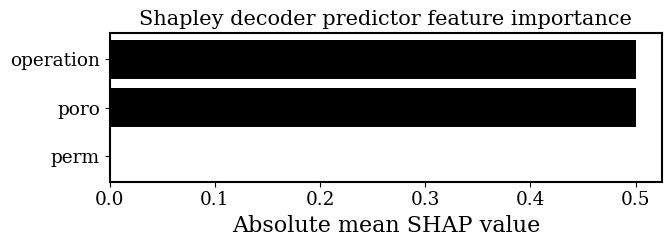

In [72]:
plot_importance_shapley('Shapley decoder predictor feature importance',
                        Importance_shapley,
                        ['operation', 'perm', 'poro'])

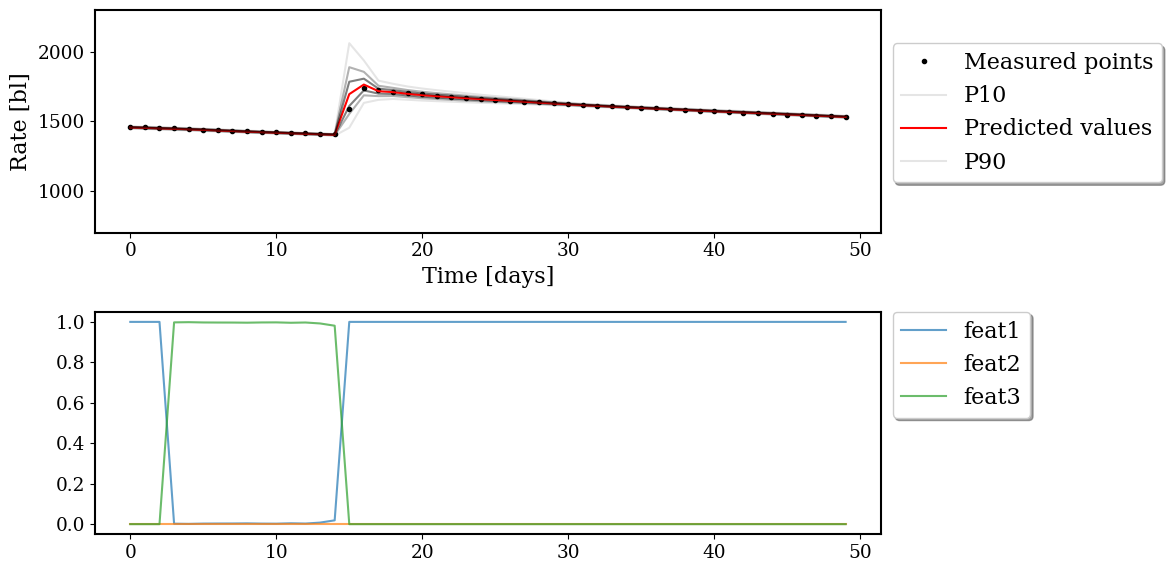

In [73]:
fig, axs = plt.subplots(2,1,figsize=(12,6))

ax=axs[0]
ax.plot(np.arange(0,50),data[data.well==Well].rate[time:time+length],'k.',label='Measured points')
#i=166
#data predicted
ax.plot(np.arange(0,50,steps),predictions_array_summary[:length,0],'k-',alpha=0.1,label='P10')
ax.plot(np.arange(0,50,steps),predictions_array_summary[:length,1],'k-',alpha=0.3)
ax.plot(np.arange(0,50,steps),predictions_array_summary[:length,2],'k-',alpha=0.5)
ax.plot(np.arange(0,50,steps),predictions_array_summary[:length,3],'r-',label = 'Predicted values')
ax.plot(np.arange(0,50,steps),predictions_array_summary[:length,4],'k-',alpha=0.5)
ax.plot(np.arange(0,50,steps),predictions_array_summary[:length,5],'k-',alpha=0.3)
ax.plot(np.arange(0,50,steps),predictions_array_summary[:length,6],'k-',alpha=0.1,label='P90')

#ax.plot([20,20],[500,2300],'k--')
ax.set_ylim(700,2300)
ax.set_ylabel('Rate [bl]')
ax.set_xlabel('Time [days]')
ax.legend(bbox_to_anchor=(1, 0.9),shadow=True)


ax2=axs[1]
#ax2.plot([20,20],[-.5,1.1],'k--')
ax2.plot(np.arange(0,50,steps),importances[:,0],color='tab:blue',label='feat1',alpha=0.7)
ax2.plot(np.arange(0,50,steps),importances[:,1],color='tab:orange',label='feat2',alpha=0.7)
ax2.plot(np.arange(0,50,steps),importances[:,2],color='tab:green',label='feat3',alpha=0.7)
# ax2.plot(np.arange(0,50,steps),importances[:,3],color='tab:red',label='feat4',alpha=0.7)
# ax2.plot(np.arange(0,50,steps),importances[:,4],color='tab:purple',label='feat5',alpha=0.7)
# ax2.plot(np.arange(0,50,steps),importances[:,5],color='tab:brown',label='feat6',alpha=0.7)
# ax2.plot(np.arange(0,50,steps),importances[:,6],color='tab:red',label='feat7',alpha=0.7)
# ax2.plot(np.arange(0,50,steps),importances[:,7],color='tab:purple',label='feat8',alpha=0.7)

ax2.legend(bbox_to_anchor=(1, 1.05),shadow=True)
ax2.set_ylim(-0.05,1.05)

fig.tight_layout()

Now, for the variables passed from the decoder to the encoder directly

In [74]:
Well = 1
steps = 1
length = 50
time=1000
predictions_array = np.zeros([length,14,7])
true_values = np.zeros([length,14])
importances = np.zeros([length,8])
mutual_information = np.zeros([length,8])
shap_values = np.zeros([length,8])
for i in range(0,length,steps):
    raw_prediction, x = best_tft.predict(
    training.filter(lambda x: (x.well == Well) & (x.time_idx_first_prediction == i+time)),
    mode="raw",
    return_x=True,
)
    #predictions.append(raw_prediction['prediction'][0,:,3])
    predictions_array[i,:,:] = raw_prediction['prediction'][0,:,:]
    true_values[i,:]=x['decoder_target'][0,:]
    
    df=pd.DataFrame()
    df['var1'] =  x["decoder_cont"][0,:,0]
    df['var2'] =  x["decoder_cont"][0,:,1]
    df['var3'] =  x["decoder_cont"][0,:,2]
    df['var4'] =  x["decoder_cont"][0,:,3]
    df['var5'] =  x["decoder_cont"][0,:,4]
    df['var6'] =  x["decoder_cont"][0,:,5]
    df['var7'] =  x["decoder_cont"][0,:,6]
    df['var8'] =  x["decoder_cont"][0,:,7]
    df['target'] = raw_prediction['prediction'][0,:,4]
    X = df.iloc[:,[0,1,2,3,4,5,6,7]]              # separate DataFrames for predictor and response features
    y = df.iloc[:,[8]]

    # xgboost for feature importance on a regression problem
    model = XGBRegressor()
    # fit the model
    model.fit(X, y)
    # get importance
    importances[i,:]=model.feature_importances_
    
    explainer = shap.TreeExplainer(model)
    sp = explainer.shap_values(X)
    sp_vals = np.average(sp,axis=0)
    #sp_vals /= np.max(sp_vals)  
    shap_values[i,:] = sp_vals
    
predictions_array_new = np.zeros([predictions_array.shape[0],predictions_array.shape[0]+predictions_array.shape[1],7],)
predictions_array_new[:] = np.nan
for i in range(predictions_array.shape[0]):
     #if i<=predictions_array.shape[0]-predictions_array.shape[1]:
    predictions_array_new[i,i:(predictions_array.shape[1]+i)] = predictions_array[i,:]
predictions_array_summary = np.nanmean(predictions_array_new,0)

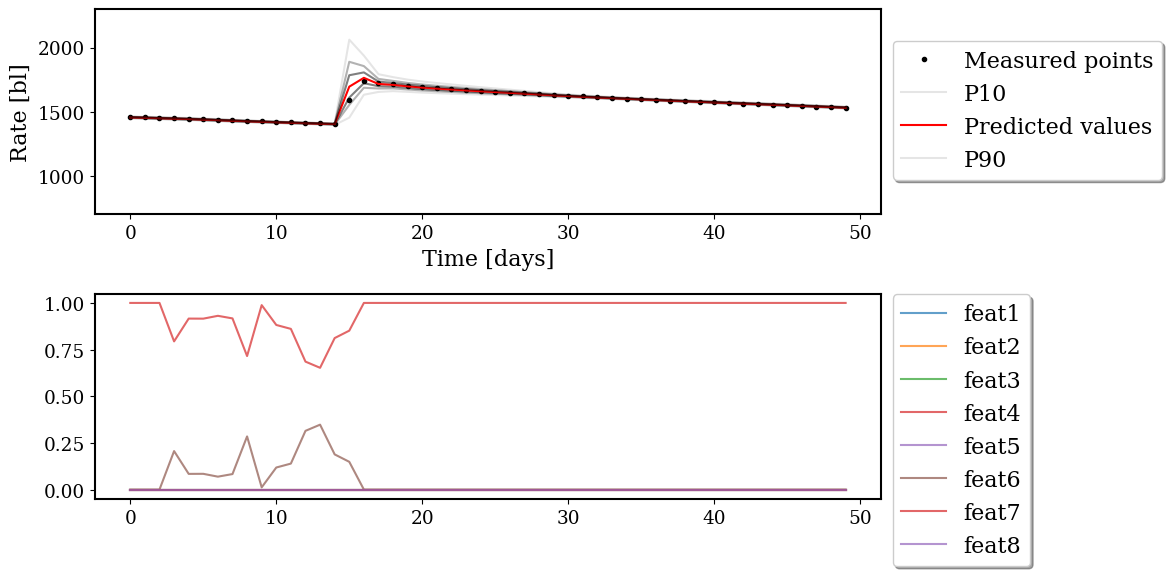

In [75]:
fig, axs = plt.subplots(2,1,figsize=(12,6))

ax=axs[0]
ax.plot(np.arange(0,50),data[data.well==Well].rate[time:time+length],'k.',label='Measured points')
#i=166
#data predicted
ax.plot(np.arange(0,50,steps),predictions_array_summary[:length,0],'k-',alpha=0.1,label='P10')
ax.plot(np.arange(0,50,steps),predictions_array_summary[:length,1],'k-',alpha=0.3)
ax.plot(np.arange(0,50,steps),predictions_array_summary[:length,2],'k-',alpha=0.5)
ax.plot(np.arange(0,50,steps),predictions_array_summary[:length,3],'r-',label = 'Predicted values')
ax.plot(np.arange(0,50,steps),predictions_array_summary[:length,4],'k-',alpha=0.5)
ax.plot(np.arange(0,50,steps),predictions_array_summary[:length,5],'k-',alpha=0.3)
ax.plot(np.arange(0,50,steps),predictions_array_summary[:length,6],'k-',alpha=0.1,label='P90')

#ax.plot([20,20],[500,2300],'k--')
ax.set_ylim(700,2300)
ax.set_ylabel('Rate [bl]')
ax.set_xlabel('Time [days]')
ax.legend(bbox_to_anchor=(1, 0.9),shadow=True)


ax2=axs[1]
#ax2.plot([20,20],[-.5,1.1],'k--')
ax2.plot(np.arange(0,50,steps),importances[:,0],color='tab:blue',label='feat1',alpha=0.7)
ax2.plot(np.arange(0,50,steps),importances[:,1],color='tab:orange',label='feat2',alpha=0.7)
ax2.plot(np.arange(0,50,steps),importances[:,2],color='tab:green',label='feat3',alpha=0.7)
ax2.plot(np.arange(0,50,steps),importances[:,3],color='tab:red',label='feat4',alpha=0.7)
ax2.plot(np.arange(0,50,steps),importances[:,4],color='tab:purple',label='feat5',alpha=0.7)
ax2.plot(np.arange(0,50,steps),importances[:,5],color='tab:brown',label='feat6',alpha=0.7)
ax2.plot(np.arange(0,50,steps),importances[:,6],color='tab:red',label='feat7',alpha=0.7)
ax2.plot(np.arange(0,50,steps),importances[:,7],color='tab:purple',label='feat8',alpha=0.7)

ax2.legend(bbox_to_anchor=(1, 1.05),shadow=True)
ax2.set_ylim(-0.05,1.05)

fig.tight_layout()

## Interpret model functions

In [76]:
interpretation = interpret_output(raw_prediction,reduction='sum')

torch.Size([1, 14, 3, 14])
torch.Size([1, 14])
torch.Size([1, 14, 3, 14])
torch.Size([1, 14, 3, 84])
torch.Size([1, 70])
torch.Size([70])


In [77]:
interpretation.keys()

dict_keys(['attention', 'static_variables', 'encoder_variables', 'decoder_variables', 'encoder_length_histogram', 'decoder_length_histogram'])

### Plot interpretation

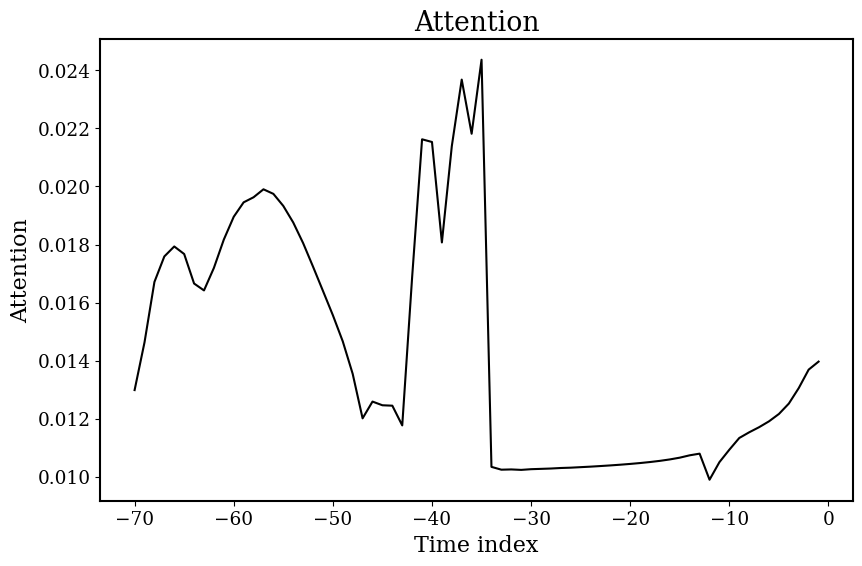

In [78]:
plot_attention(interpretation);

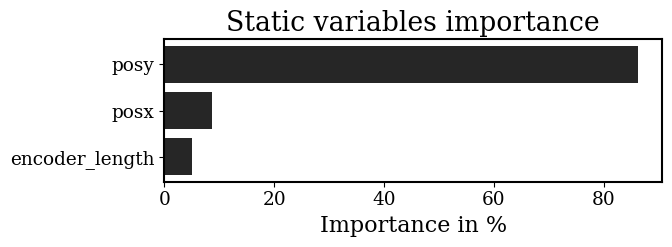

In [79]:
plot_static_variable_importance(interpretation);

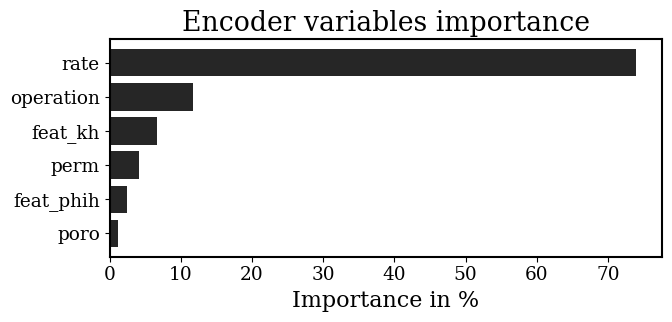

In [80]:
plot_encoder_variables(interpretation);

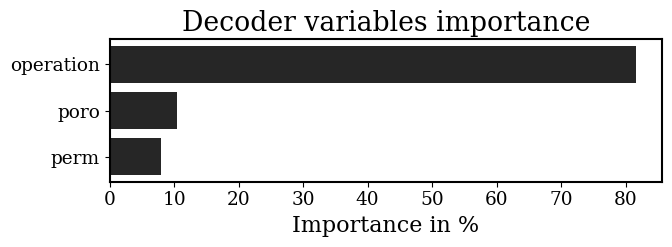

In [81]:
plot_decoder_variables(interpretation);